In [2]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import bicgstab
import Reader as rd
from glob import glob
import matplotlib.patches as patches
import pandas as pd
import math
from scipy.misc import imread
import bcolz

import os

#### Methods

$normalization = v^{T}Dv$

$correlation = \frac{(v^{T}Ds)^2} {normalization}$

$score = \frac{v^{T}Lv}{normalization}$

In [3]:
def e_neighbour_graph(img, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    if(row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            result[row * colN + col][(row + rowDiff) * colN + (col + colDiff)] = 1
    return result


def fully_connected_graph(img, sigma):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for row2 in range(rowN):
                for col2 in range(colN):
                    weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                    result[row * colN + col][row2 * colN + col2] = weight
    return result


def fully_connected_e_neighbour_graph(img, sigma, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    if(row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            row2 = row + rowDiff
                            col2 = col + colDiff
                            weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                            result[row * colN + col][row2 * colN + col2] = weight
    return result

def laplacian(graph):
    diag = np.diag(sum(graph))
    lap = diag - graph
    return [lap, diag]


def orthogonalize(diag, s):
    nodeNum = len(diag)
    p = np.ones((nodeNum, 1)) / pow(sum(np.diag(np.diag(sum(diag)))), .5)
    projection = np.dot(np.transpose(s), np.dot(diag, p))
    v = s - projection[0][0] * p
    # return [v, projection]
    return v


def PRwalk(graph, alpha, s):
    if alpha < 0:
        print('Error: alpha must be positive!')
        return -1
    nodeNum = len(graph)
    [L, D] = laplacian(graph)
    s = orthogonalize(D, s)
    v, flag = bicgstab((L + alpha * D), np.dot(D, s),tol=1e-3, maxiter=nodeNum)

    v = np.reshape(v, (len(v), 1))

    v = orthogonalize(D, v)
    return v

def PRobjective(graph, seed, myImg):
    
    [L, D] = laplacian(graph)
    s = orthogonalize(D, seed)
    s = normalize(D, s)
    print('Threshold: ' + str(1 / len(graph)))
    alphaList = []    
    correlationList = []
    scoreList = []
    valueList = []
    
    exponential = -9
    correlation = 1 / len(graph) + 1 # to get into loop
    
    MAXITER = 21
    # MINITER = 4
    for i in range(MAXITER):
        # if correlation > 1 / len(graph):
        oldCorrelation = correlation
        exponential -= 1
        alpha = 2 ** exponential
        v = PRwalk(graph, alpha, s)
        normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
        correlation = \
            (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
        score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]
        alphaList.append(alpha)
        correlationList.append(correlation)
        scoreList.append(score)
        valueList.append(v)

        print('--')
        print('alpha: 2^' + str(exponential))
        print('Correlation: ' + str(correlation))
        print('Score: ' + str(score))
        print('Heatmap:\n')
        heat = np.zeros(myImg.shape)
        for ii in range(myImg.shape[0]):
            for jj in range(myImg.shape[1]):
                heat[ii][jj] = v[ii * myImg.shape[1] + jj]    
        plt.imshow(heat, cmap='hot', interpolation='nearest')
        plt.show()
            
        # if i == MINITER:
        #    print('**')
        #    print('Starting correlation decrease check!')
            
        # if i >= MINITER and oldCorrelation * .99 < correlation:
        #    break
            
    print('****')
    plt.plot(correlationList, scoreList, 'r*--')
    plt.xlabel('Correlation')
    plt.ylabel('Score')
    plt.show()
    
    return [alphaList, correlationList, scoreList, valueList]

def normalize(D, s):
    norm = np.dot(np.dot(np.transpose(s), D), s)
    v = s/math.sqrt(norm)
    return v

def save_array(fname, arr):
    c = bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

#### Image

In [5]:
# 1a10297e6c3101af33003e6c4f846f47
IMAGE = "1a10297e6c3101af33003e6c4f846f47"
myImg = np.asarray(imread(IMAGE + "/" + IMAGE + ".aps.jpg"), dtype=np.int)
# 148 row, 176 columns
graph = fully_connected_e_neighbour_graph(myImg, 5, 3)
seedList = ['Normalised Intensity', 'Normalised Intensity Square to between 0 1', [40,90],[40,65],[45,123],[30,100]]
for i in range(25, 122, 48):
    for j in range(60, 125, 32):
        seedList.append([i,j])
alphaListList = []
correlationListList = []
scoreListList = []
valueListList = []

#### Trying seed as normalised full image

$seed[i] = \frac{intensity[i]}{\sqrt{\sum intensity^2}}$

Threshold: 3.839066339066339e-05
--
alpha: 2^-10
Correlation: 0.916850674152
Score: 0.000959490413882
Heatmap:



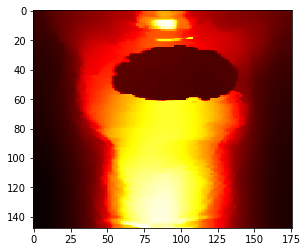

--
alpha: 2^-11
Correlation: 0.886974594915
Score: 0.00090587945138
Heatmap:



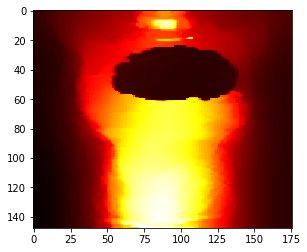

--
alpha: 2^-12
Correlation: 0.847369559334
Score: 0.000850024386091
Heatmap:



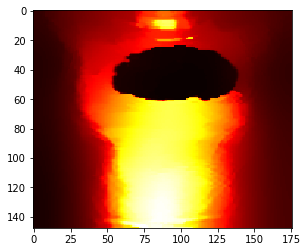

--
alpha: 2^-13
Correlation: 0.803469469909
Score: 0.00079692203478
Heatmap:



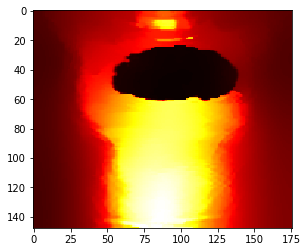

--
alpha: 2^-14
Correlation: 0.766972371146
Score: 0.000756707317054
Heatmap:



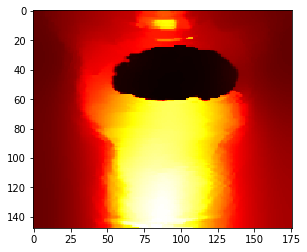

--
alpha: 2^-15
Correlation: 0.742337243065
Score: 0.000730969121968
Heatmap:



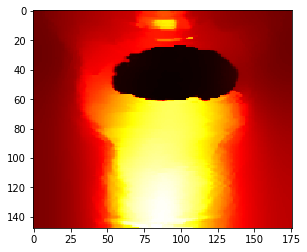

--
alpha: 2^-16
Correlation: 0.727802606131
Score: 0.000716219688869
Heatmap:



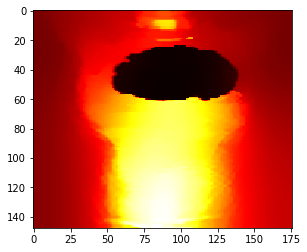

--
alpha: 2^-17
Correlation: 0.720095888569
Score: 0.000708518729605
Heatmap:



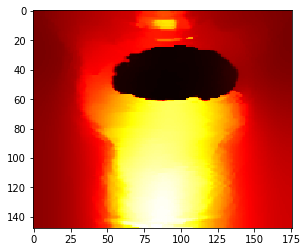

--
alpha: 2^-18
Correlation: 0.71653308254
Score: 0.000704985268109
Heatmap:



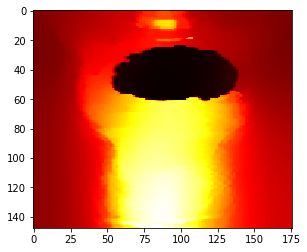

--
alpha: 2^-19
Correlation: 0.713575636419
Score: 0.000702060395645
Heatmap:



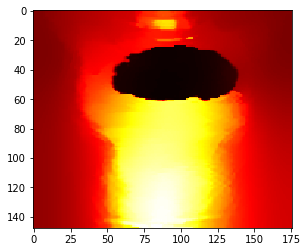

--
alpha: 2^-20
Correlation: 0.713116566065
Score: 0.000701610451857
Heatmap:



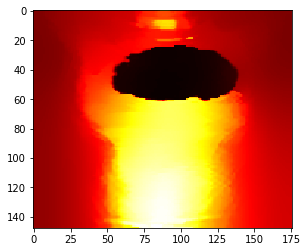

--
alpha: 2^-21
Correlation: 0.71282580735
Score: 0.000701324724566
Heatmap:



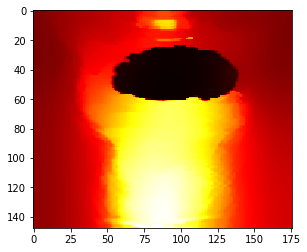

--
alpha: 2^-22
Correlation: 0.712263241971
Score: 0.000700767525475
Heatmap:



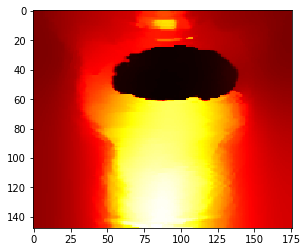

--
alpha: 2^-23
Correlation: 0.712357086959
Score: 0.000700862736761
Heatmap:



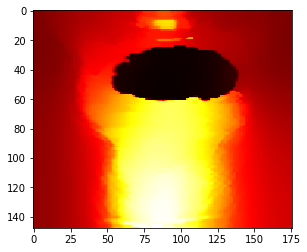

--
alpha: 2^-24
Correlation: 0.711495807464
Score: 0.000700012768328
Heatmap:



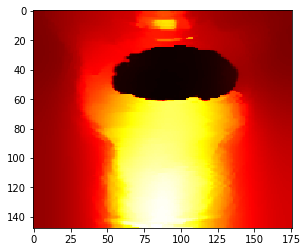

--
alpha: 2^-25
Correlation: 0.712429254912
Score: 0.000700933331267
Heatmap:



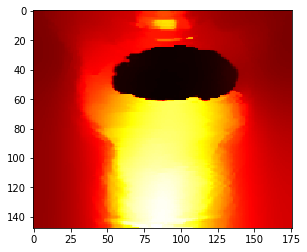

--
alpha: 2^-26
Correlation: 0.71195285441
Score: 0.000700464771308
Heatmap:



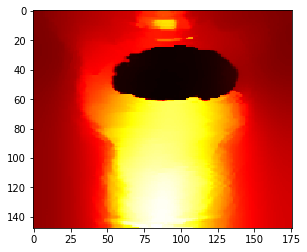

--
alpha: 2^-27
Correlation: 0.712450091439
Score: 0.000700952610131
Heatmap:



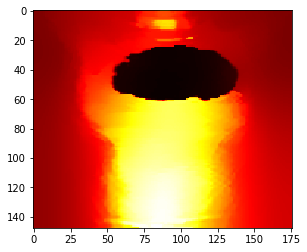

--
alpha: 2^-28
Correlation: 0.711944294733
Score: 0.000700456346648
Heatmap:



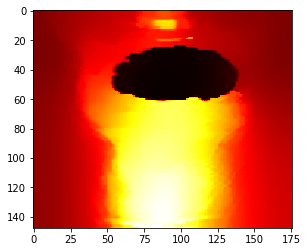

--
alpha: 2^-29
Correlation: 0.711989187615
Score: 0.000700500592244
Heatmap:



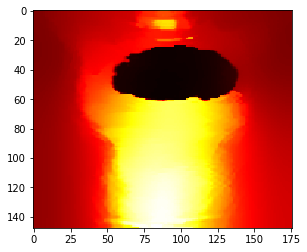

--
alpha: 2^-30
Correlation: 0.712038832601
Score: 0.000700549647289
Heatmap:



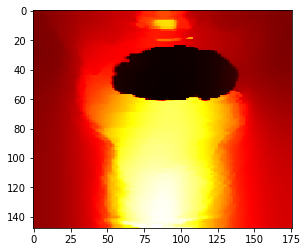

****


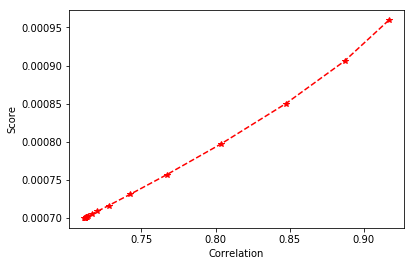

In [4]:
# Seed initialisation
seed = myImg.copy()
seed = seed.reshape(myImg.shape[0] * myImg.shape[1], 1)
seed = seed / math.sqrt(sum(sum(seed * seed)))

[alphaList, correlationList, scoreList, valueList] = PRobjective(graph, seed, myImg)

# Saving
alphaListList.append(alphaList)
correlationListList.append(correlationList)
scoreListList.append(scoreList)
valueListList.append(valueList)

#### Trying seed as normalised Intensity Square to between 0 and 1

$seed[i] = \frac{intensity[i]^2 - min(intensity^2)}{max(intensity^2) - min(intensity^2)}$

Threshold: 3.839066339066339e-05
--
alpha: 2^-10
Correlation: 0.873537698063
Score: 0.000912671121627
Heatmap:



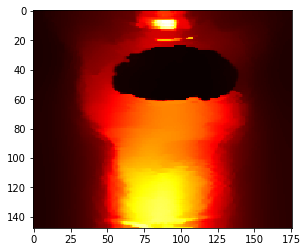

--
alpha: 2^-11
Correlation: 0.825393911664
Score: 0.000824542259667
Heatmap:



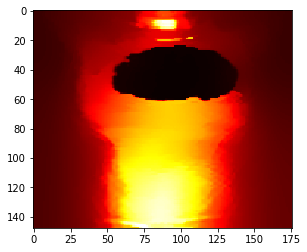

--
alpha: 2^-12
Correlation: 0.764478922691
Score: 0.000738161422364
Heatmap:



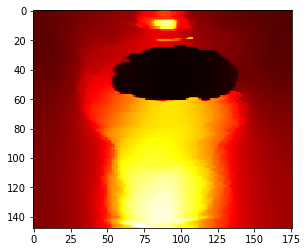

--
alpha: 2^-13
Correlation: 0.703905751699
Score: 0.000665749652504
Heatmap:



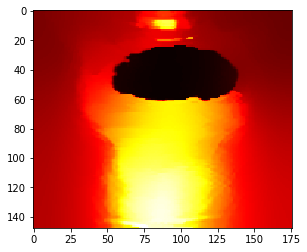

--
alpha: 2^-14
Correlation: 0.656612064515
Score: 0.000615031890049
Heatmap:



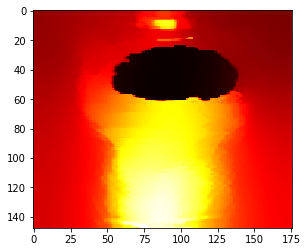

--
alpha: 2^-15
Correlation: 0.626568520668
Score: 0.000584834249813
Heatmap:



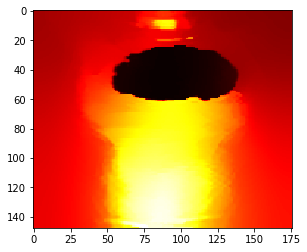

--
alpha: 2^-16
Correlation: 0.609491588036
Score: 0.000568276069117
Heatmap:



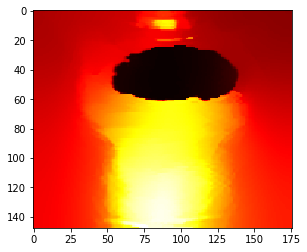

--
alpha: 2^-17
Correlation: 0.60033122471
Score: 0.000559561584637
Heatmap:



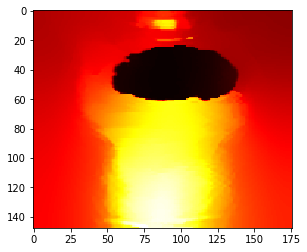

--
alpha: 2^-18
Correlation: 0.595084111115
Score: 0.000554619925999
Heatmap:



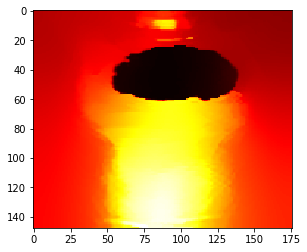

--
alpha: 2^-19
Correlation: 0.593110374268
Score: 0.000552772870994
Heatmap:



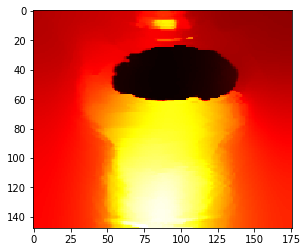

--
alpha: 2^-20
Correlation: 0.591865713287
Score: 0.00055160939645
Heatmap:



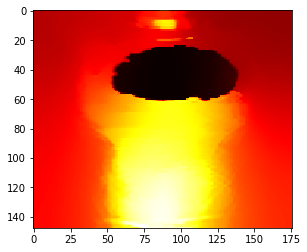

--
alpha: 2^-21
Correlation: 0.591458473945
Score: 0.000551229760454
Heatmap:



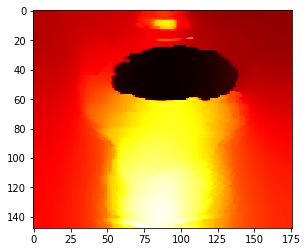

--
alpha: 2^-22
Correlation: 0.591095513125
Score: 0.000550890955517
Heatmap:



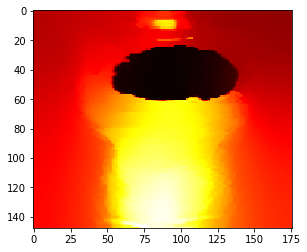

--
alpha: 2^-23
Correlation: 0.591037727157
Score: 0.00055083705366
Heatmap:



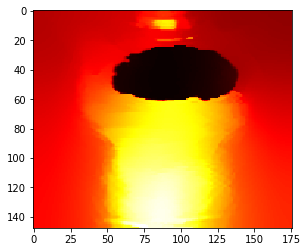

--
alpha: 2^-24
Correlation: 0.590856472568
Score: 0.00055066796525
Heatmap:



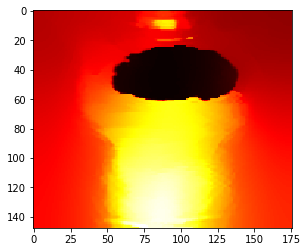

--
alpha: 2^-25
Correlation: 0.590809469826
Score: 0.000550624144092
Heatmap:



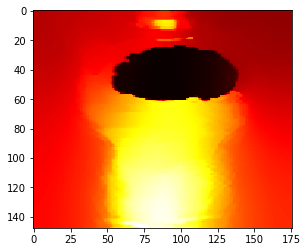

--
alpha: 2^-26
Correlation: 0.590727968198
Score: 0.000550547756653
Heatmap:



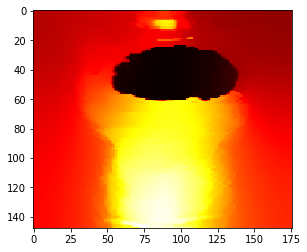

--
alpha: 2^-27
Correlation: 0.590670026218
Score: 0.000550493871416
Heatmap:



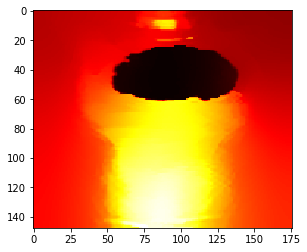

--
alpha: 2^-28
Correlation: 0.591037190107
Score: 0.000550836094975
Heatmap:



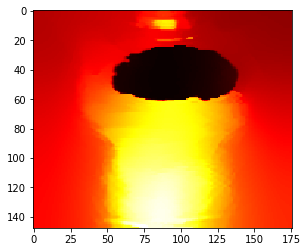

--
alpha: 2^-29
Correlation: 0.59075992014
Score: 0.000550576792162
Heatmap:



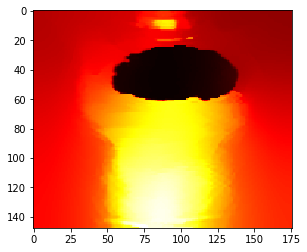

--
alpha: 2^-30
Correlation: 0.590740469631
Score: 0.000550559739872
Heatmap:



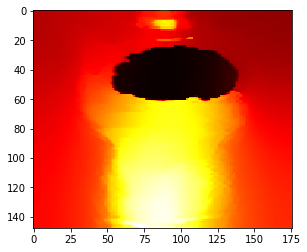

****


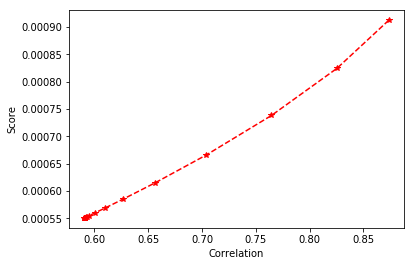

In [5]:
# Seed initialisation
seed = myImg.copy()
seed = seed.reshape(myImg.shape[0] * myImg.shape[1], 1)
seed = seed * seed
seed = (seed - min(seed)) / (max(seed) - min(seed))

[alphaList, correlationList, scoreList, valueList] = PRobjective(graph, seed, myImg)

# Saving
alphaListList.append(alphaList)
correlationListList.append(correlationList)
scoreListList.append(scoreList)
valueListList.append(valueList)

#### Trying seedList that is randomly taken in and outside of threat

--------Seed [40, 90]
Threshold: 3.839066339066339e-05
--
alpha: 2^-10
Correlation: 0.0127295214906
Score: 0.00671109975807
Heatmap:



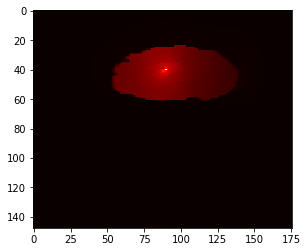

--
alpha: 2^-11
Correlation: 0.0059406158583
Score: 0.00276482724251
Heatmap:



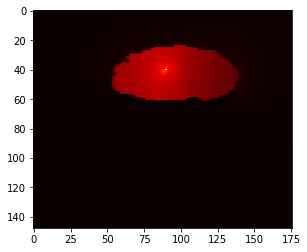

--
alpha: 2^-12
Correlation: 0.0033740075994
Score: 0.00141752628092
Heatmap:



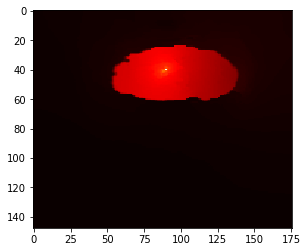

--
alpha: 2^-13
Correlation: 0.00229314854973
Score: 0.000904902133787
Heatmap:



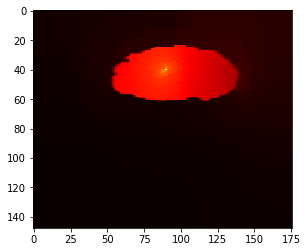

--
alpha: 2^-14
Correlation: 0.00181875523132
Score: 0.000698094628287
Heatmap:



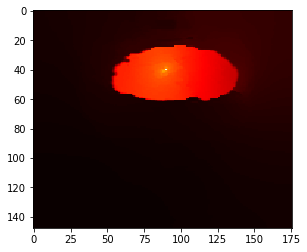

--
alpha: 2^-15
Correlation: 0.00159002953583
Score: 0.000603889855239
Heatmap:



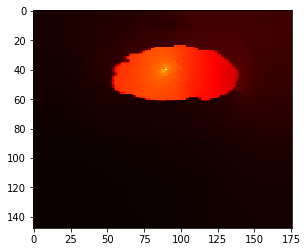

--
alpha: 2^-16
Correlation: 0.00147843296425
Score: 0.000559528269246
Heatmap:



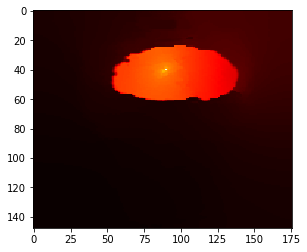

--
alpha: 2^-17
Correlation: 0.00142088688389
Score: 0.000537097292953
Heatmap:



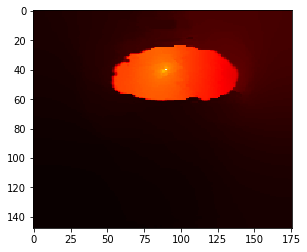

--
alpha: 2^-18
Correlation: 0.0013926989236
Score: 0.000526232116708
Heatmap:



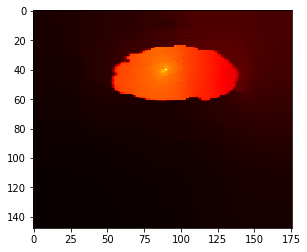

--
alpha: 2^-19
Correlation: 0.00137253703263
Score: 0.000518486496471
Heatmap:



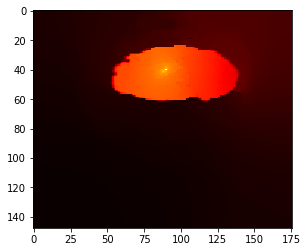

--
alpha: 2^-20
Correlation: 0.00137671561313
Score: 0.000520050825737
Heatmap:



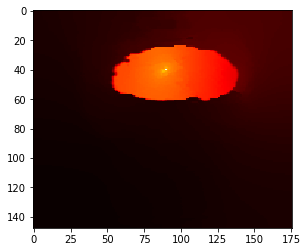

--
alpha: 2^-21
Correlation: 0.00136903692642
Score: 0.000517166899996
Heatmap:



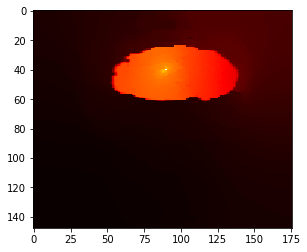

--
alpha: 2^-22
Correlation: 0.00137331126426
Score: 0.000518713706982
Heatmap:



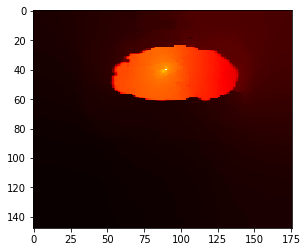

--
alpha: 2^-23
Correlation: 0.00137558081521
Score: 0.000519695097489
Heatmap:



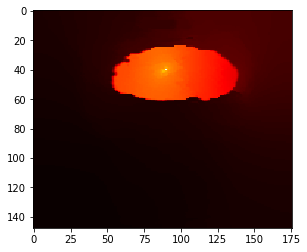

--
alpha: 2^-24
Correlation: 0.00135583896888
Score: 0.000512042300117
Heatmap:



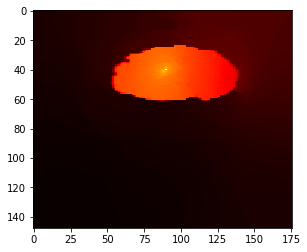

--
alpha: 2^-25
Correlation: 0.00137033977178
Score: 0.000517658791044
Heatmap:



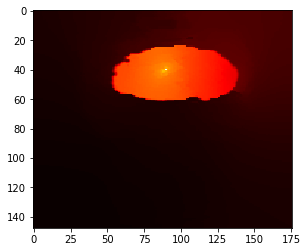

--
alpha: 2^-26
Correlation: 0.00135830322695
Score: 0.000513054990657
Heatmap:



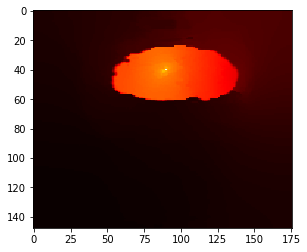

--
alpha: 2^-27
Correlation: 0.00135454028103
Score: 0.000511582566618
Heatmap:



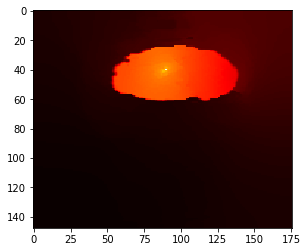

--
alpha: 2^-28
Correlation: 0.00137099586503
Score: 0.000517941854528
Heatmap:



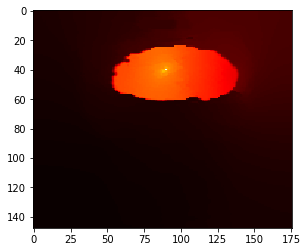

--
alpha: 2^-29
Correlation: 0.00136364016113
Score: 0.000515079998618
Heatmap:



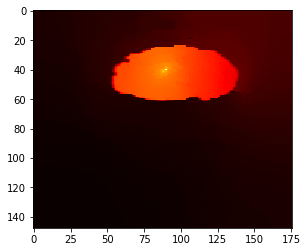

--
alpha: 2^-30
Correlation: 0.00137241484187
Score: 0.000518390410812
Heatmap:



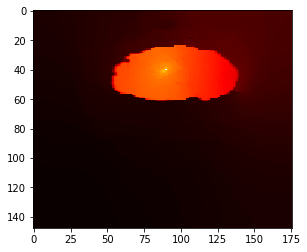

****


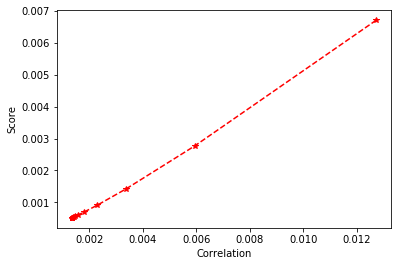

--------Seed [40, 65]
Threshold: 3.839066339066339e-05
--
alpha: 2^-10
Correlation: 0.0117277756772
Score: 0.0047363665522
Heatmap:



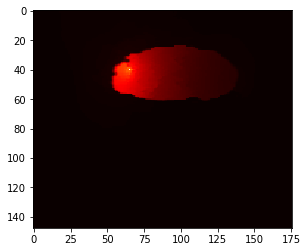

--
alpha: 2^-11
Correlation: 0.00646613472898
Score: 0.00229332112812
Heatmap:



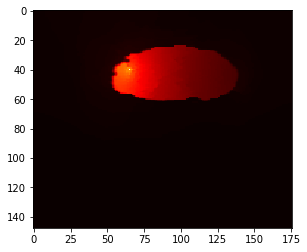

--
alpha: 2^-12
Correlation: 0.00403559917304
Score: 0.00129618765317
Heatmap:



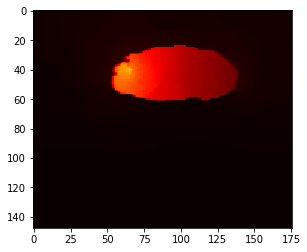

--
alpha: 2^-13
Correlation: 0.00292366139462
Score: 0.000887478586246
Heatmap:



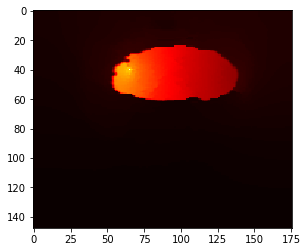

--
alpha: 2^-14
Correlation: 0.002339546009
Score: 0.0006907151825
Heatmap:



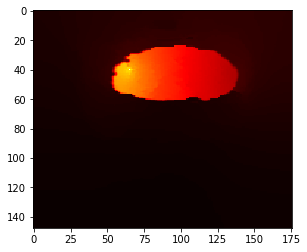

--
alpha: 2^-15
Correlation: 0.00208097458298
Score: 0.000608785430571
Heatmap:



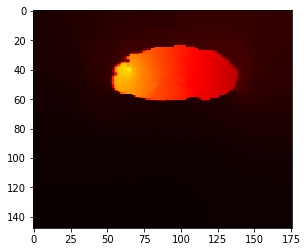

--
alpha: 2^-16
Correlation: 0.00192240522123
Score: 0.000560078476512
Heatmap:



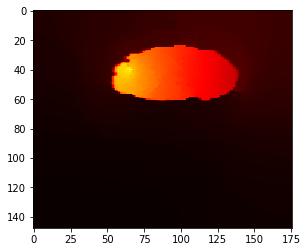

--
alpha: 2^-17
Correlation: 0.00189090449858
Score: 0.00055081647761
Heatmap:



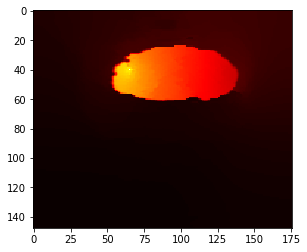

--
alpha: 2^-18
Correlation: 0.00183935980803
Score: 0.000535486911663
Heatmap:



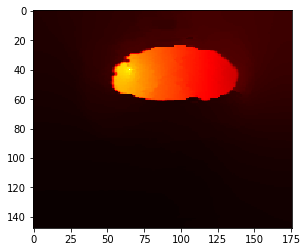

--
alpha: 2^-19
Correlation: 0.00182257067142
Score: 0.000530465695973
Heatmap:



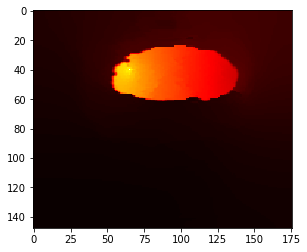

--
alpha: 2^-20
Correlation: 0.00181131363622
Score: 0.000527209033172
Heatmap:



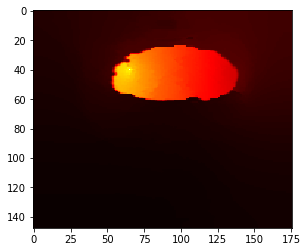

--
alpha: 2^-21
Correlation: 0.00182388409041
Score: 0.000530863348662
Heatmap:



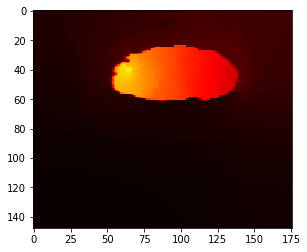

--
alpha: 2^-22
Correlation: 0.00181467605959
Score: 0.000528218247891
Heatmap:



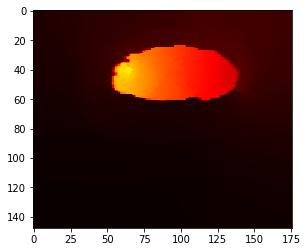

--
alpha: 2^-23
Correlation: 0.00181589225219
Score: 0.000528583057881
Heatmap:



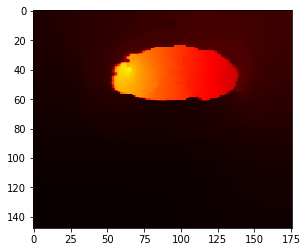

--
alpha: 2^-24
Correlation: 0.00180643795036
Score: 0.000525756110998
Heatmap:



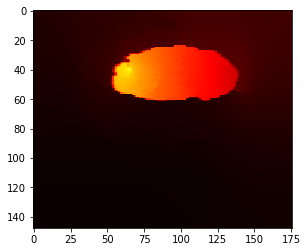

--
alpha: 2^-25
Correlation: 0.00182432208293
Score: 0.000530926375921
Heatmap:



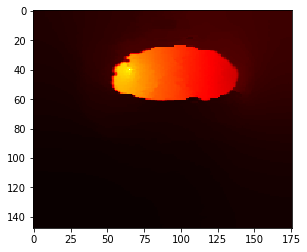

--
alpha: 2^-26
Correlation: 0.00180990587156
Score: 0.000526817324171
Heatmap:



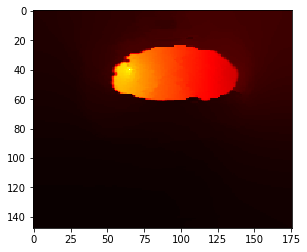

--
alpha: 2^-27
Correlation: 0.0018069074968
Score: 0.00052591202883
Heatmap:



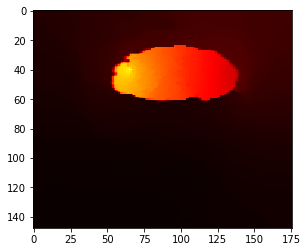

--
alpha: 2^-28
Correlation: 0.0018084535697
Score: 0.000526383288234
Heatmap:



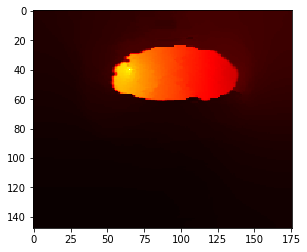

--
alpha: 2^-29
Correlation: 0.00182969715849
Score: 0.000532626732956
Heatmap:



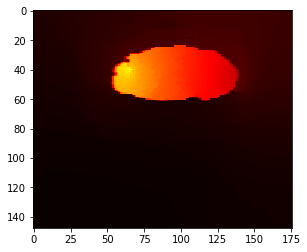

--
alpha: 2^-30
Correlation: 0.00182750904421
Score: 0.000532003768796
Heatmap:



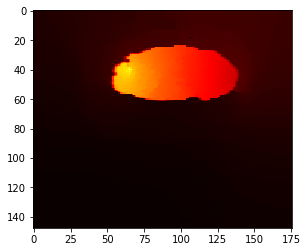

****


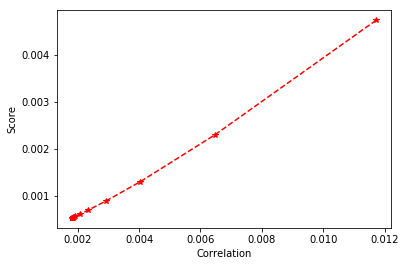

--------Seed [45, 123]
Threshold: 3.839066339066339e-05
--
alpha: 2^-10
Correlation: 0.0113656867882
Score: 0.00492507423704
Heatmap:



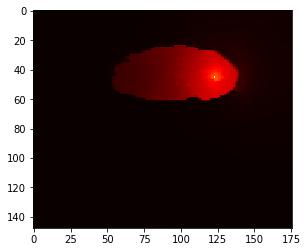

--
alpha: 2^-11
Correlation: 0.00590665367487
Score: 0.00221803052485
Heatmap:



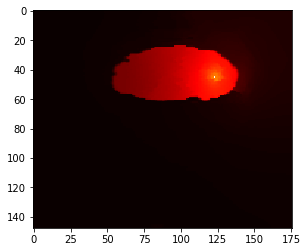

--
alpha: 2^-12
Correlation: 0.00354489529985
Score: 0.00118774917456
Heatmap:



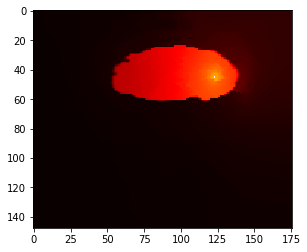

--
alpha: 2^-13
Correlation: 0.00248210159466
Score: 0.000776241287156
Heatmap:



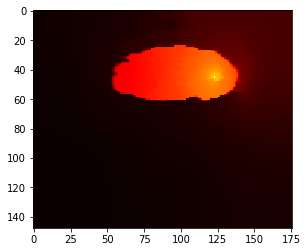

--
alpha: 2^-14
Correlation: 0.00197637177118
Score: 0.000598357438949
Heatmap:



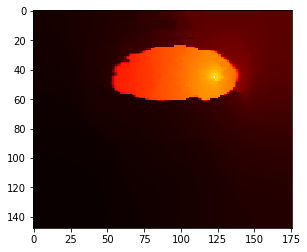

--
alpha: 2^-15
Correlation: 0.00173733458235
Score: 0.000519813150283
Heatmap:



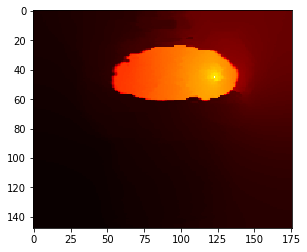

--
alpha: 2^-16
Correlation: 0.00161185232606
Score: 0.000480192941598
Heatmap:



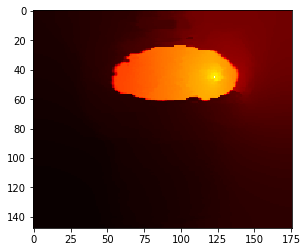

--
alpha: 2^-17
Correlation: 0.0015670451624
Score: 0.000466435918368
Heatmap:



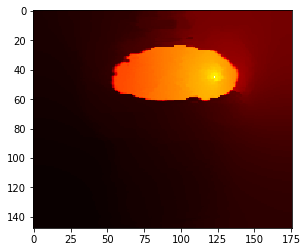

--
alpha: 2^-18
Correlation: 0.00153802176783
Score: 0.000457658033839
Heatmap:



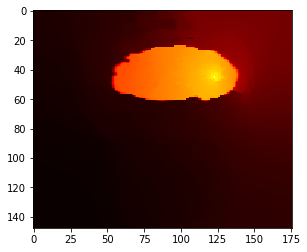

--
alpha: 2^-19
Correlation: 0.00154772443956
Score: 0.000460436369163
Heatmap:



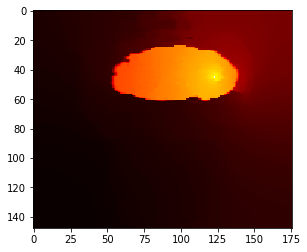

--
alpha: 2^-20
Correlation: 0.00151829256605
Score: 0.000451635685913
Heatmap:



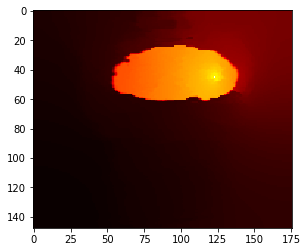

--
alpha: 2^-21
Correlation: 0.00150721039923
Score: 0.000448276116457
Heatmap:



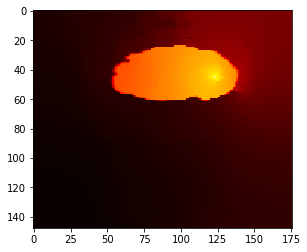

--
alpha: 2^-22
Correlation: 0.00151142604727
Score: 0.000449490524105
Heatmap:



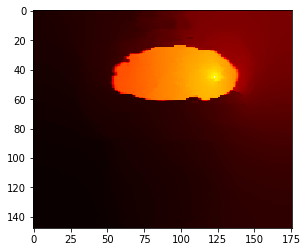

--
alpha: 2^-23
Correlation: 0.00150736375758
Score: 0.000448308129166
Heatmap:



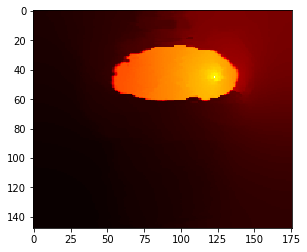

--
alpha: 2^-24
Correlation: 0.00150873700117
Score: 0.000448595895021
Heatmap:



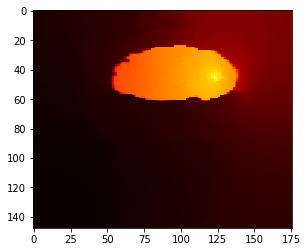

--
alpha: 2^-25
Correlation: 0.00149568335026
Score: 0.000444666008976
Heatmap:



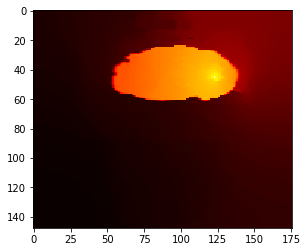

--
alpha: 2^-26
Correlation: 0.0015026777974
Score: 0.000446888628356
Heatmap:



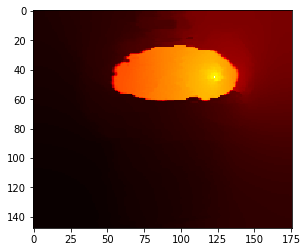

--
alpha: 2^-27
Correlation: 0.00150781256536
Score: 0.000448486821014
Heatmap:



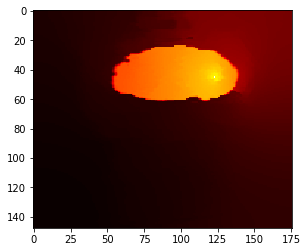

--
alpha: 2^-28
Correlation: 0.00150849321822
Score: 0.000448706840618
Heatmap:



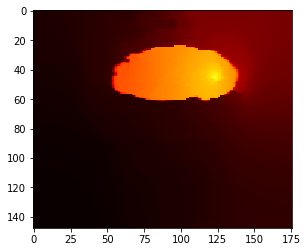

--
alpha: 2^-29
Correlation: 0.00150616459785
Score: 0.000447965238123
Heatmap:



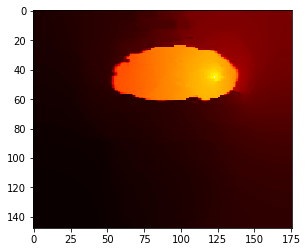

--
alpha: 2^-30
Correlation: 0.00150812878936
Score: 0.00044859288959
Heatmap:



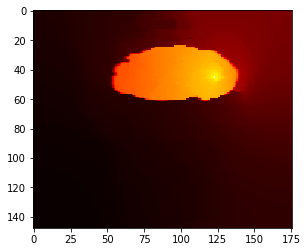

****


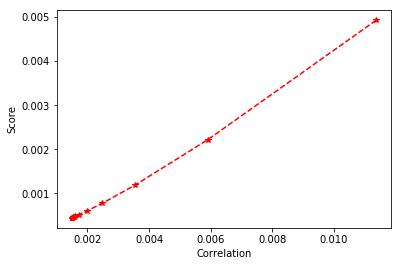

--------Seed [30, 100]
Threshold: 3.839066339066339e-05
--
alpha: 2^-10
Correlation: 0.0126692551648
Score: 0.0057495346853
Heatmap:



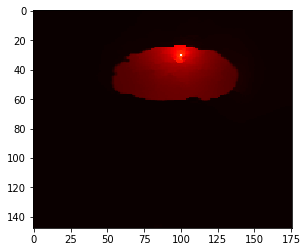

--
alpha: 2^-11
Correlation: 0.00620779348741
Score: 0.00246355789958
Heatmap:



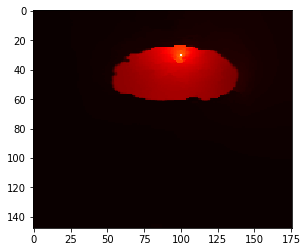

--
alpha: 2^-12
Correlation: 0.00361487370873
Score: 0.00128602836353
Heatmap:



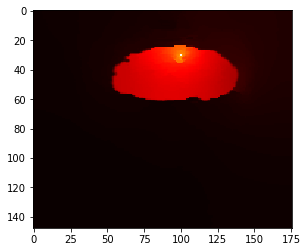

--
alpha: 2^-13
Correlation: 0.00249554733186
Score: 0.000831075270612
Heatmap:



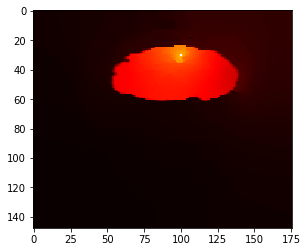

--
alpha: 2^-14
Correlation: 0.00199012868728
Score: 0.000643275210596
Heatmap:



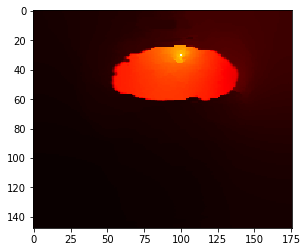

--
alpha: 2^-15
Correlation: 0.00174076314675
Score: 0.000556269529359
Heatmap:



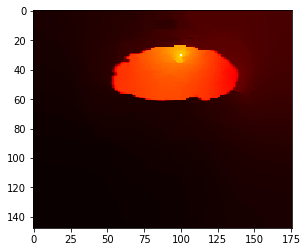

--
alpha: 2^-16
Correlation: 0.00162573605759
Score: 0.000517592506685
Heatmap:



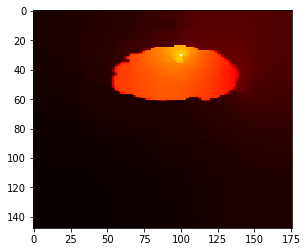

--
alpha: 2^-17
Correlation: 0.00155777767321
Score: 0.000495290559481
Heatmap:



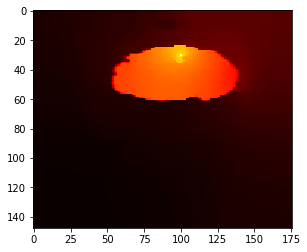

--
alpha: 2^-18
Correlation: 0.0015493515504
Score: 0.000492442615133
Heatmap:



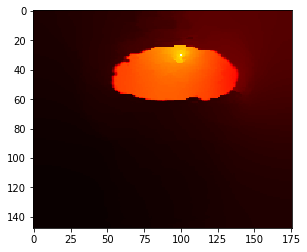

--
alpha: 2^-19
Correlation: 0.00152007318098
Score: 0.00048303419032
Heatmap:



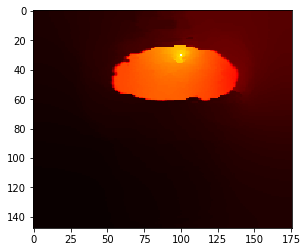

--
alpha: 2^-20
Correlation: 0.001515027252
Score: 0.000481465209592
Heatmap:



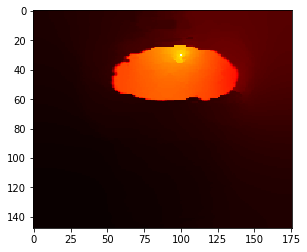

--
alpha: 2^-21
Correlation: 0.00151681867329
Score: 0.000482048128496
Heatmap:



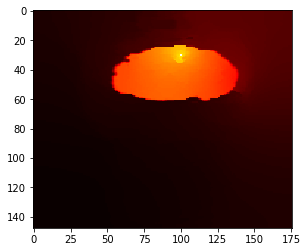

--
alpha: 2^-22
Correlation: 0.00151266630517
Score: 0.000480709939169
Heatmap:



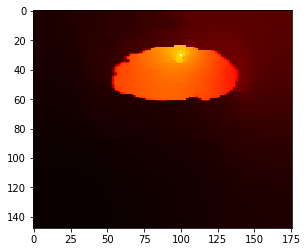

--
alpha: 2^-23
Correlation: 0.00150513680728
Score: 0.000478284180916
Heatmap:



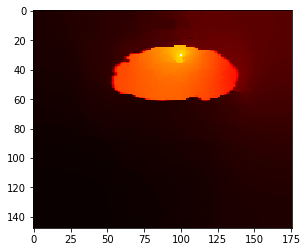

--
alpha: 2^-24
Correlation: 0.00151198552727
Score: 0.000480481147539
Heatmap:



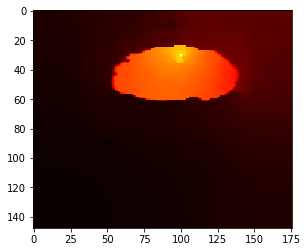

--
alpha: 2^-25
Correlation: 0.00149562345657
Score: 0.000475037636541
Heatmap:



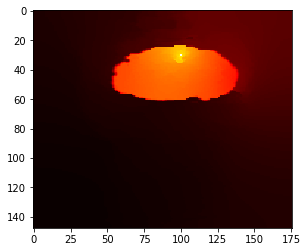

--
alpha: 2^-26
Correlation: 0.00150028984894
Score: 0.000476707911944
Heatmap:



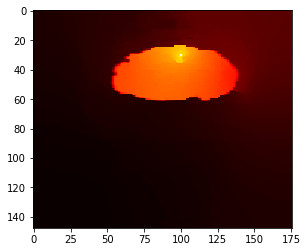

--
alpha: 2^-27
Correlation: 0.00151324879031
Score: 0.000480877196984
Heatmap:



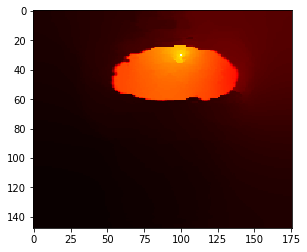

--
alpha: 2^-28
Correlation: 0.00149425423815
Score: 0.000474711782319
Heatmap:



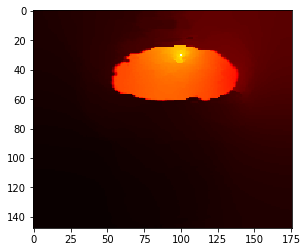

--
alpha: 2^-29
Correlation: 0.00150712438284
Score: 0.000478868654327
Heatmap:



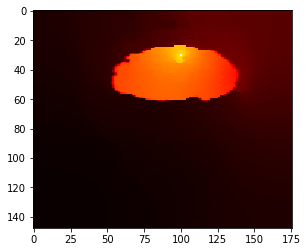

--
alpha: 2^-30
Correlation: 0.00150132009131
Score: 0.000476930046901
Heatmap:



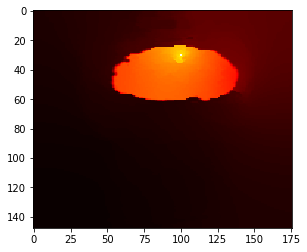

****


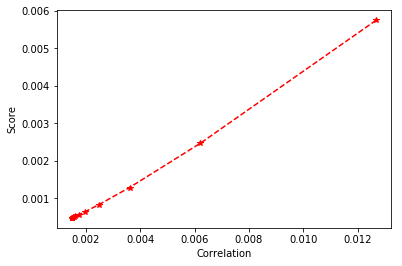

--------Seed [25, 60]
Threshold: 3.839066339066339e-05
--
alpha: 2^-10
Correlation: 0.02231783883
Score: 0.0106457033643
Heatmap:



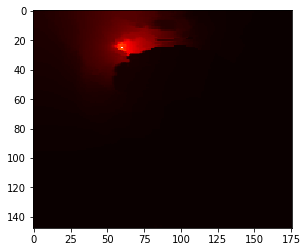

--
alpha: 2^-11
Correlation: 0.01292013131
Score: 0.00585953627337
Heatmap:



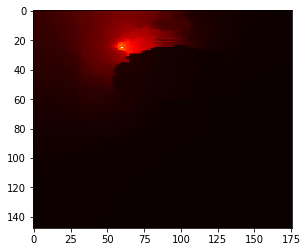

--
alpha: 2^-12
Correlation: 0.00820414084959
Score: 0.00358482397247
Heatmap:



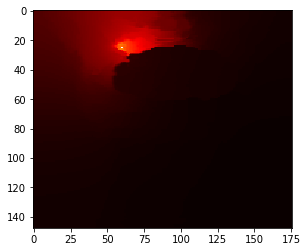

--
alpha: 2^-13
Correlation: 0.00583853431741
Score: 0.00249468852112
Heatmap:



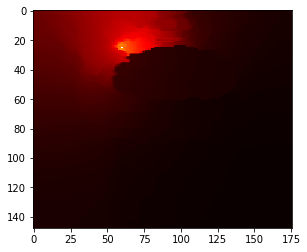

--
alpha: 2^-14
Correlation: 0.00460866218889
Score: 0.00194679814141
Heatmap:



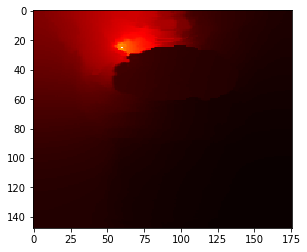

--
alpha: 2^-15
Correlation: 0.00399495792969
Score: 0.00167947380991
Heatmap:



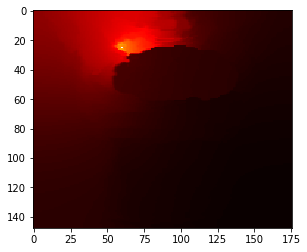

--
alpha: 2^-16
Correlation: 0.00372966771434
Score: 0.00156553149196
Heatmap:



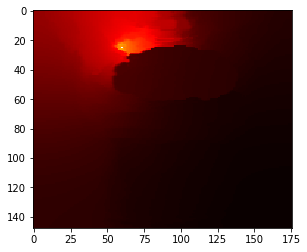

--
alpha: 2^-17
Correlation: 0.00357635961839
Score: 0.00150007212683
Heatmap:



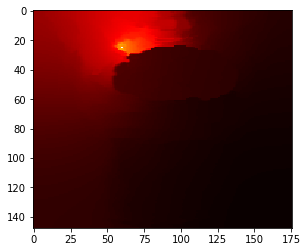

--
alpha: 2^-18
Correlation: 0.00350511573283
Score: 0.00146980255457
Heatmap:



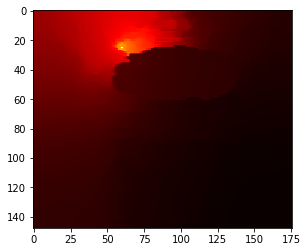

--
alpha: 2^-19
Correlation: 0.00344768350514
Score: 0.00144542328452
Heatmap:



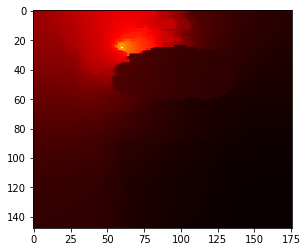

--
alpha: 2^-20
Correlation: 0.0034952229476
Score: 0.0014654473912
Heatmap:



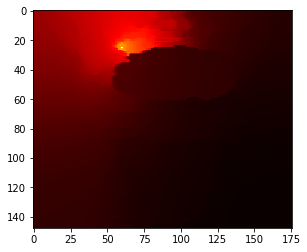

--
alpha: 2^-21
Correlation: 0.00323876487057
Score: 0.00135718213824
Heatmap:



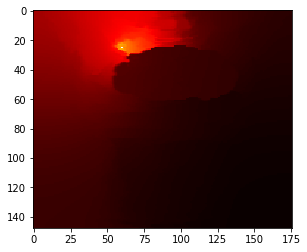

--
alpha: 2^-22
Correlation: 0.00337706130601
Score: 0.0014155565638
Heatmap:



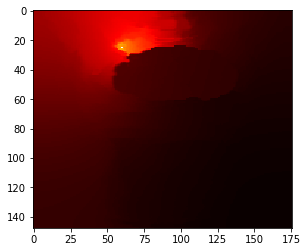

--
alpha: 2^-23
Correlation: 0.00345754975003
Score: 0.00144953622942
Heatmap:



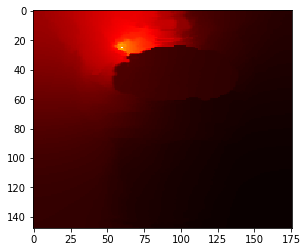

--
alpha: 2^-24
Correlation: 0.00337963020235
Score: 0.00141650440922
Heatmap:



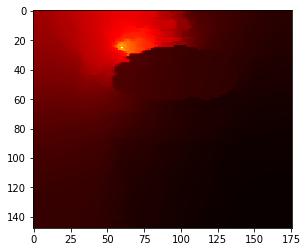

--
alpha: 2^-25
Correlation: 0.00346779048462
Score: 0.0014534076656
Heatmap:



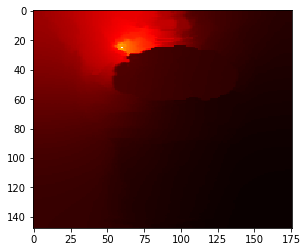

--
alpha: 2^-26
Correlation: 0.00345263578667
Score: 0.00144711469157
Heatmap:



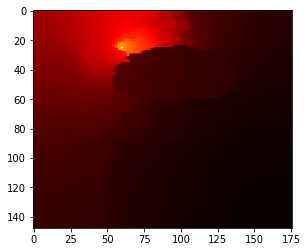

--
alpha: 2^-27
Correlation: 0.0033936756504
Score: 0.00142258022806
Heatmap:



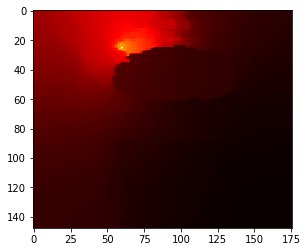

--
alpha: 2^-28
Correlation: 0.00335976002941
Score: 0.00140785943187
Heatmap:



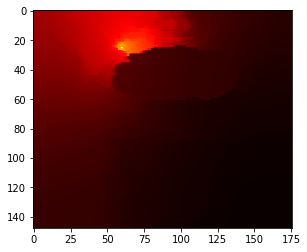

--
alpha: 2^-29
Correlation: 0.0034142152324
Score: 0.00143120084759
Heatmap:



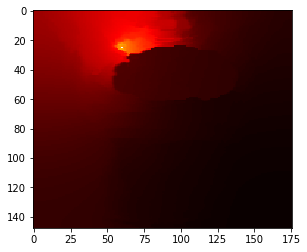

--
alpha: 2^-30
Correlation: 0.00348790667808
Score: 0.00146224637496
Heatmap:



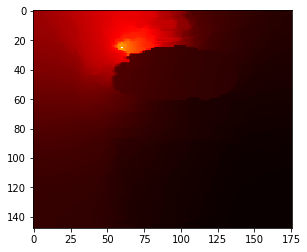

****


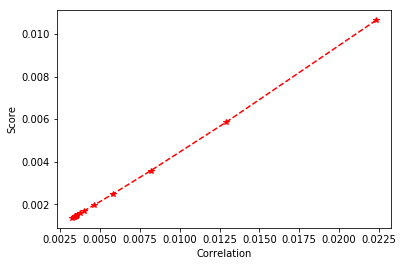

--------Seed [25, 92]
Threshold: 3.839066339066339e-05
--
alpha: 2^-10
Correlation: 0.0166855144036
Score: 0.0083554989688
Heatmap:



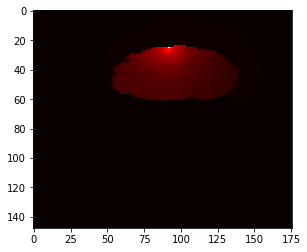

--
alpha: 2^-11
Correlation: 0.00791241247096
Score: 0.00359932323422
Heatmap:



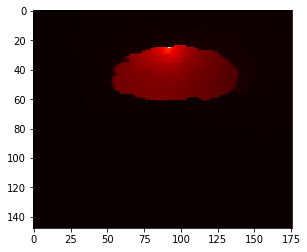

--
alpha: 2^-12
Correlation: 0.00435502386864
Score: 0.00182172222723
Heatmap:



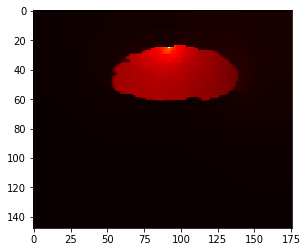

--
alpha: 2^-13
Correlation: 0.00288198283039
Score: 0.00114354062086
Heatmap:



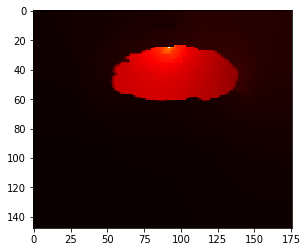

--
alpha: 2^-14
Correlation: 0.0022054522668
Score: 0.000852715594696
Heatmap:



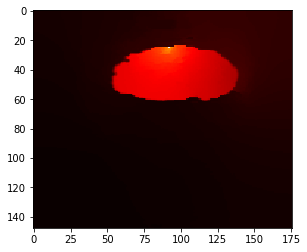

--
alpha: 2^-15
Correlation: 0.00191560561803
Score: 0.000734162928984
Heatmap:



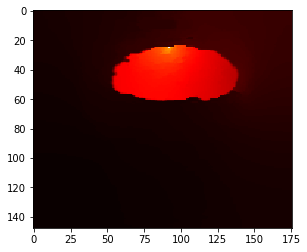

--
alpha: 2^-16
Correlation: 0.00175037491887
Score: 0.000668530911194
Heatmap:



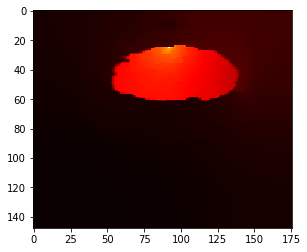

--
alpha: 2^-17
Correlation: 0.00168275350687
Score: 0.000642105078329
Heatmap:



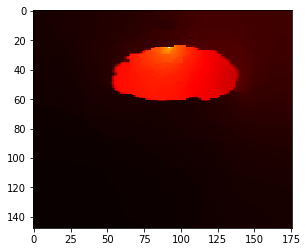

--
alpha: 2^-18
Correlation: 0.00165054957414
Score: 0.000629453055188
Heatmap:



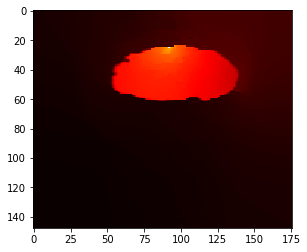

--
alpha: 2^-19
Correlation: 0.00162035631402
Score: 0.000617951366194
Heatmap:



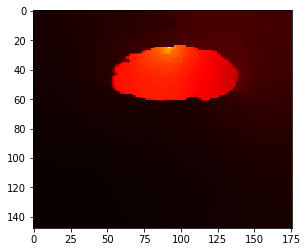

--
alpha: 2^-20
Correlation: 0.00161137356296
Score: 0.000614420329755
Heatmap:



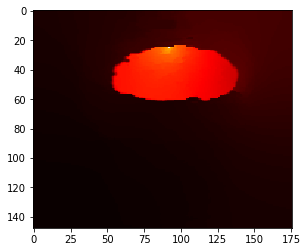

--
alpha: 2^-21
Correlation: 0.00161812189602
Score: 0.000617082084345
Heatmap:



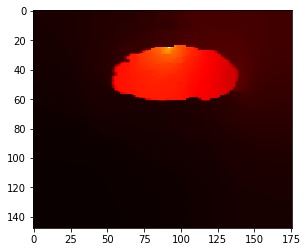

--
alpha: 2^-22
Correlation: 0.00161015668835
Score: 0.00061405849031
Heatmap:



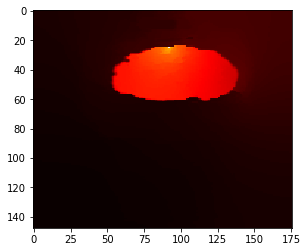

--
alpha: 2^-23
Correlation: 0.00162229078638
Score: 0.000618727495019
Heatmap:



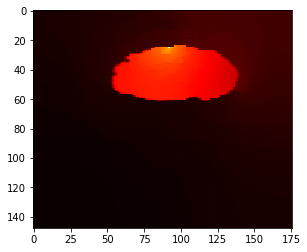

--
alpha: 2^-24
Correlation: 0.00162833828797
Score: 0.000621064072918
Heatmap:



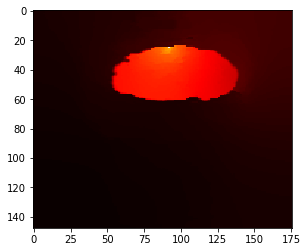

--
alpha: 2^-25
Correlation: 0.00161949600867
Score: 0.000617666553328
Heatmap:



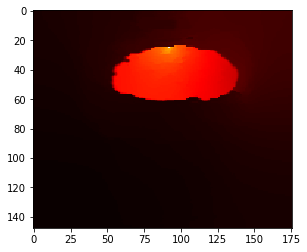

--
alpha: 2^-26
Correlation: 0.00161126704604
Score: 0.000614488604225
Heatmap:



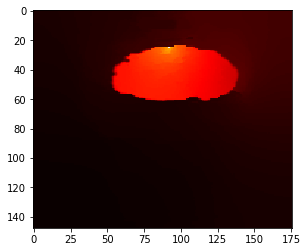

--
alpha: 2^-27
Correlation: 0.00160984222571
Score: 0.0006139324535
Heatmap:



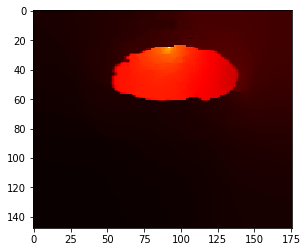

--
alpha: 2^-28
Correlation: 0.00161777395253
Score: 0.000616831586935
Heatmap:



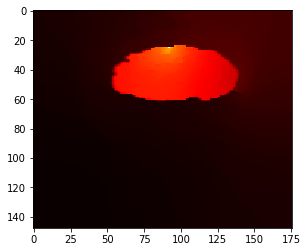

--
alpha: 2^-29
Correlation: 0.00160512951346
Score: 0.000612022685587
Heatmap:



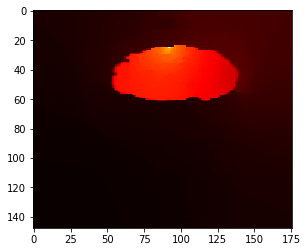

--
alpha: 2^-30
Correlation: 0.00159996102749
Score: 0.000610102707295
Heatmap:



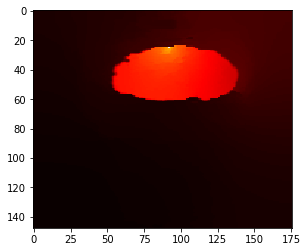

****


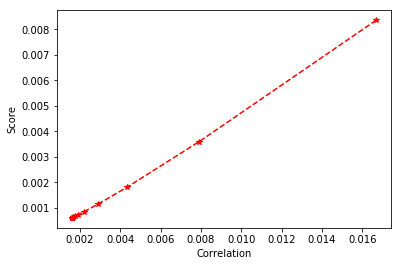

--------Seed [25, 124]
Threshold: 3.839066339066339e-05
--
alpha: 2^-10
Correlation: 0.0172695457421
Score: 0.00784170269074
Heatmap:



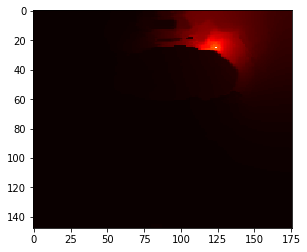

--
alpha: 2^-11
Correlation: 0.00974630573191
Score: 0.00411900693465
Heatmap:



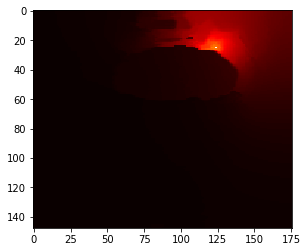

--
alpha: 2^-12
Correlation: 0.0060058227962
Score: 0.00239842752517
Heatmap:



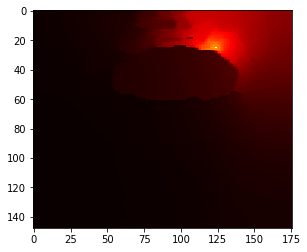

--
alpha: 2^-13
Correlation: 0.00415840516578
Score: 0.00160094920845
Heatmap:



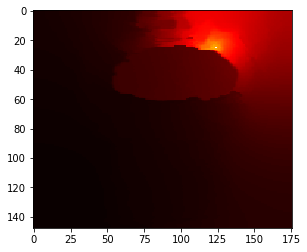

--
alpha: 2^-14
Correlation: 0.00318421237837
Score: 0.0012021145994
Heatmap:



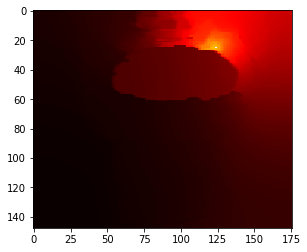

--
alpha: 2^-15
Correlation: 0.00272164909827
Score: 0.0010192657499
Heatmap:



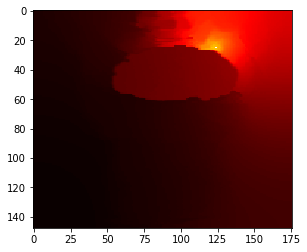

--
alpha: 2^-16
Correlation: 0.00253007988913
Score: 0.000944993499749
Heatmap:



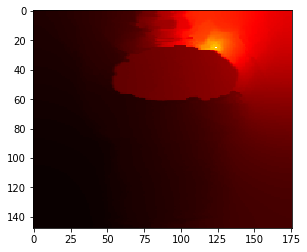

--
alpha: 2^-17
Correlation: 0.00237151398759
Score: 0.000883644044061
Heatmap:



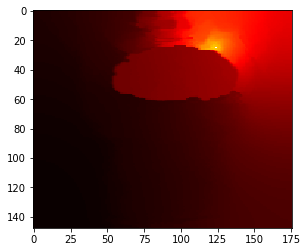

--
alpha: 2^-18
Correlation: 0.00230214325189
Score: 0.000857862739092
Heatmap:



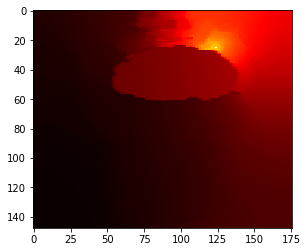

--
alpha: 2^-19
Correlation: 0.00228147197298
Score: 0.000850175386484
Heatmap:



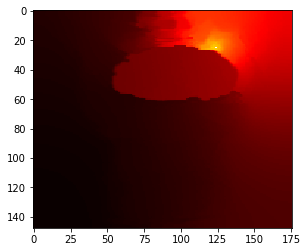

--
alpha: 2^-20
Correlation: 0.00226027709181
Score: 0.000842097741191
Heatmap:



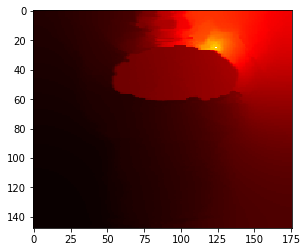

--
alpha: 2^-21
Correlation: 0.00227193465806
Score: 0.000846452466477
Heatmap:



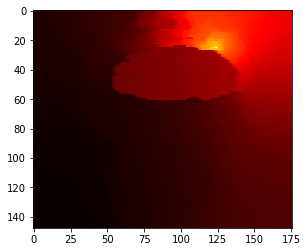

--
alpha: 2^-22
Correlation: 0.00228717208956
Score: 0.000852196825873
Heatmap:



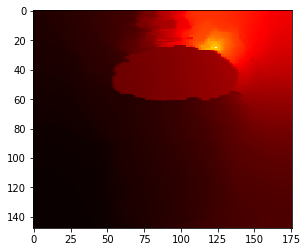

--
alpha: 2^-23
Correlation: 0.0022499999099
Score: 0.00083782219758
Heatmap:



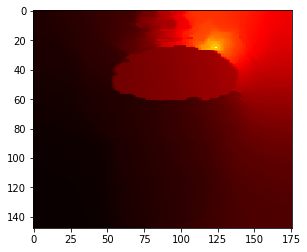

--
alpha: 2^-24
Correlation: 0.00222881526305
Score: 0.000830182088391
Heatmap:



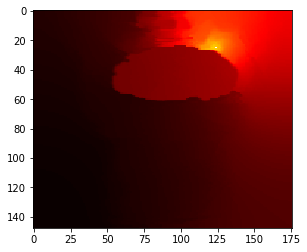

--
alpha: 2^-25
Correlation: 0.00223383149638
Score: 0.000832148274137
Heatmap:



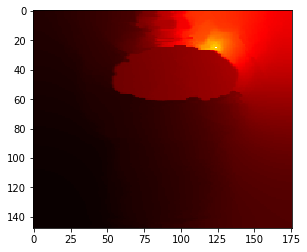

--
alpha: 2^-26
Correlation: 0.00223678433504
Score: 0.000833204365529
Heatmap:



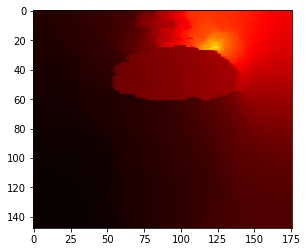

--
alpha: 2^-27
Correlation: 0.00223494305258
Score: 0.000832488746753
Heatmap:



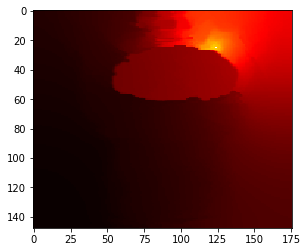

--
alpha: 2^-28
Correlation: 0.00230934709378
Score: 0.000860237663505
Heatmap:



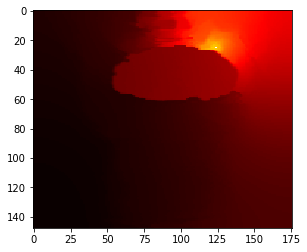

--
alpha: 2^-29
Correlation: 0.00228141638101
Score: 0.00085003289181
Heatmap:



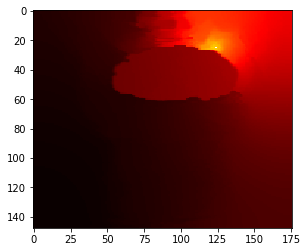

--
alpha: 2^-30
Correlation: 0.00227537980504
Score: 0.000847822724909
Heatmap:



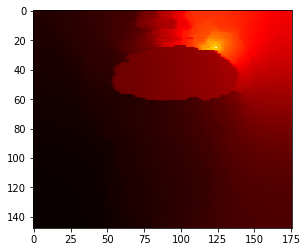

****


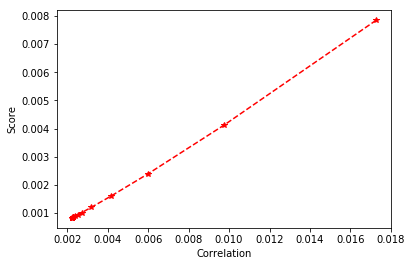

--------Seed [73, 60]
Threshold: 3.839066339066339e-05
--
alpha: 2^-10
Correlation: 0.0231622612807
Score: 0.0122467886212
Heatmap:



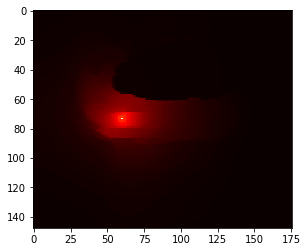

--
alpha: 2^-11
Correlation: 0.0160110806534
Score: 0.00823354733453
Heatmap:



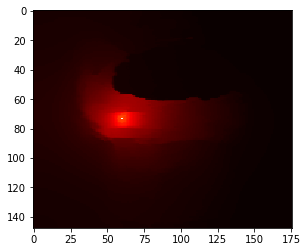

--
alpha: 2^-12
Correlation: 0.00981402965297
Score: 0.00491161375062
Heatmap:



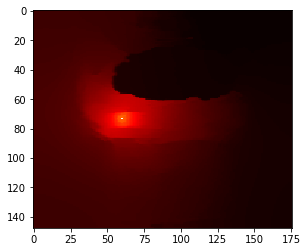

--
alpha: 2^-13
Correlation: 0.00922678844195
Score: 0.00460813240159
Heatmap:



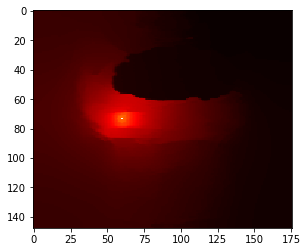

--
alpha: 2^-14
Correlation: 0.00719598957152
Score: 0.00356254333247
Heatmap:



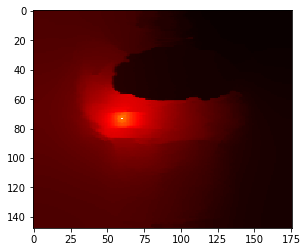

--
alpha: 2^-15
Correlation: 0.00645456507902
Score: 0.00318517388742
Heatmap:



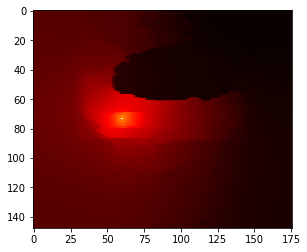

--
alpha: 2^-16
Correlation: 0.00572848736203
Score: 0.00281951345508
Heatmap:



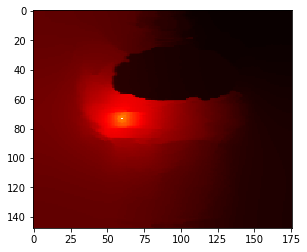

--
alpha: 2^-17
Correlation: 0.00536009389443
Score: 0.00263533293148
Heatmap:



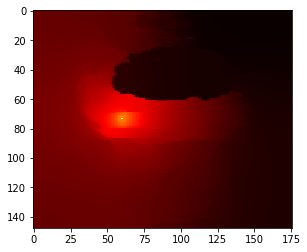

--
alpha: 2^-18
Correlation: 0.00543947203367
Score: 0.00267477499097
Heatmap:



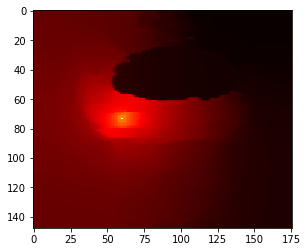

--
alpha: 2^-19
Correlation: 0.00528969722637
Score: 0.00259976002557
Heatmap:



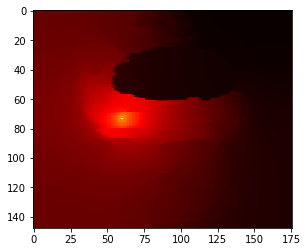

--
alpha: 2^-20
Correlation: 0.00504350592872
Score: 0.00247704892651
Heatmap:



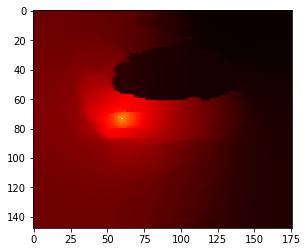

--
alpha: 2^-21
Correlation: 0.00504175239407
Score: 0.00247610620206
Heatmap:



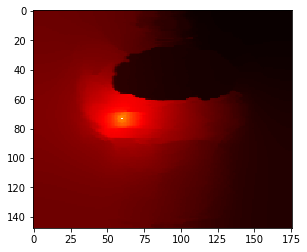

--
alpha: 2^-22
Correlation: 0.00538966703618
Score: 0.00264962010781
Heatmap:



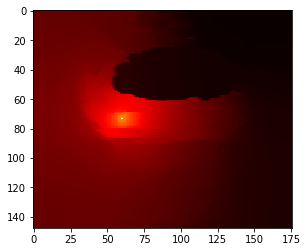

--
alpha: 2^-23
Correlation: 0.0050223877577
Score: 0.00246709077393
Heatmap:



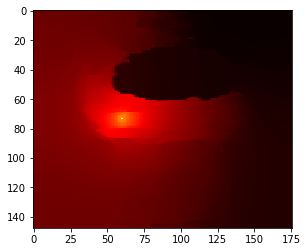

--
alpha: 2^-24
Correlation: 0.00511855200196
Score: 0.00251470178269
Heatmap:



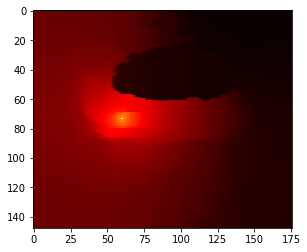

--
alpha: 2^-25
Correlation: 0.00463961137212
Score: 0.0022768466879
Heatmap:



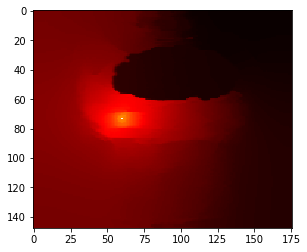

--
alpha: 2^-26
Correlation: 0.00533119058688
Score: 0.00262077926354
Heatmap:



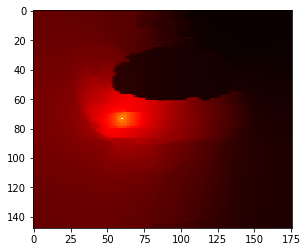

--
alpha: 2^-27
Correlation: 0.00522897539122
Score: 0.00256919731113
Heatmap:



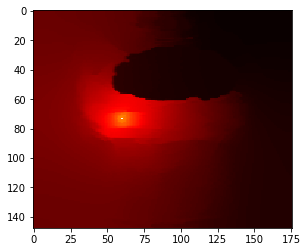

--
alpha: 2^-28
Correlation: 0.00488916480784
Score: 0.00240049291922
Heatmap:



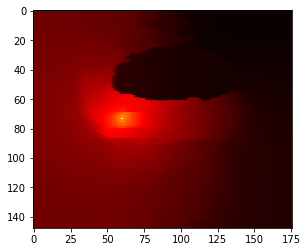

--
alpha: 2^-29
Correlation: 0.00479171862282
Score: 0.00235236532521
Heatmap:



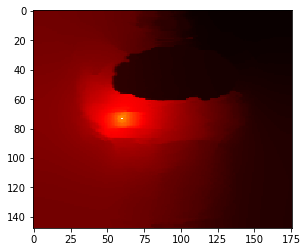

--
alpha: 2^-30
Correlation: 0.00476720488224
Score: 0.0023398031938
Heatmap:



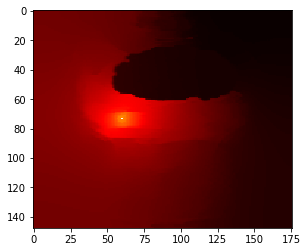

****


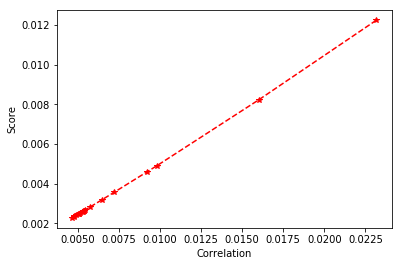

--------Seed [73, 92]
Threshold: 3.839066339066339e-05
--
alpha: 2^-10
Correlation: 0.0192598667692
Score: 0.0105426689024
Heatmap:



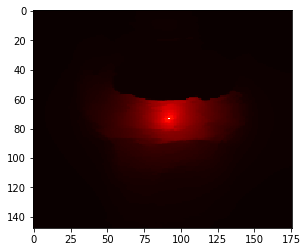

--
alpha: 2^-11
Correlation: 0.0136549458105
Score: 0.00726013220896
Heatmap:



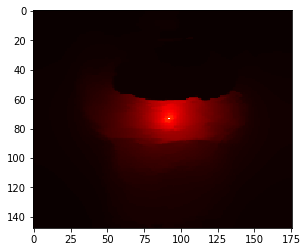

--
alpha: 2^-12
Correlation: 0.0106149398024
Score: 0.00555547400248
Heatmap:



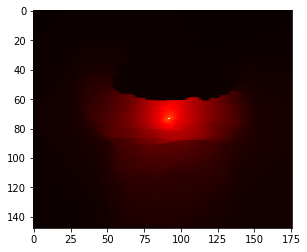

--
alpha: 2^-13
Correlation: 0.00897604022883
Score: 0.00466153104862
Heatmap:



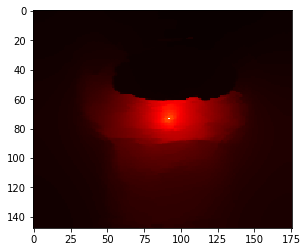

--
alpha: 2^-14
Correlation: 0.00809320872606
Score: 0.00418959797808
Heatmap:



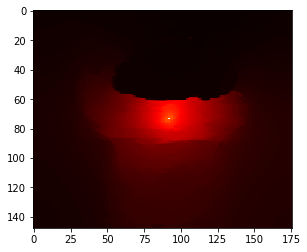

--
alpha: 2^-15
Correlation: 0.00725170403891
Score: 0.00374392292639
Heatmap:



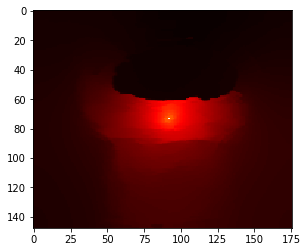

--
alpha: 2^-16
Correlation: 0.00743230326542
Score: 0.00384025528744
Heatmap:



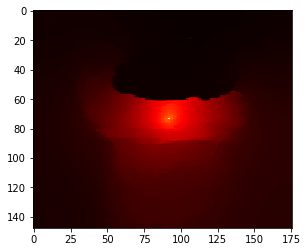

--
alpha: 2^-17
Correlation: 0.00734320398027
Score: 0.00379327545134
Heatmap:



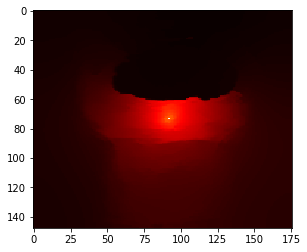

--
alpha: 2^-18
Correlation: 0.00710135470332
Score: 0.00366461601584
Heatmap:



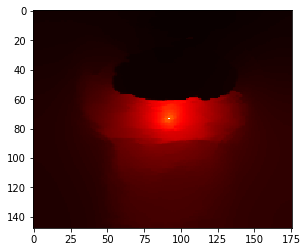

--
alpha: 2^-19
Correlation: 0.00723171719585
Score: 0.00373403265398
Heatmap:



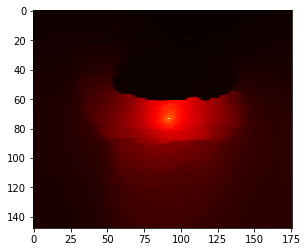

--
alpha: 2^-20
Correlation: 0.00717615241261
Score: 0.0037057147545
Heatmap:



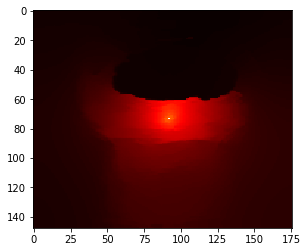

--
alpha: 2^-21
Correlation: 0.00714925012485
Score: 0.00369112550729
Heatmap:



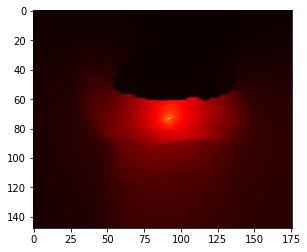

--
alpha: 2^-22
Correlation: 0.00714976871878
Score: 0.00369084117012
Heatmap:



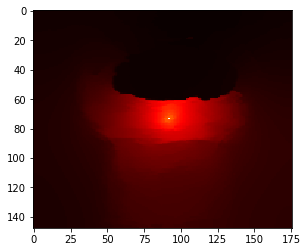

--
alpha: 2^-23
Correlation: 0.00720867396037
Score: 0.00372262487005
Heatmap:



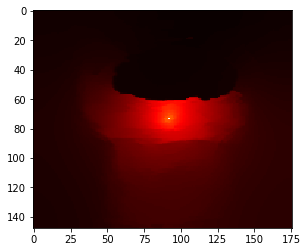

--
alpha: 2^-24
Correlation: 0.00718358688722
Score: 0.00370946731358
Heatmap:



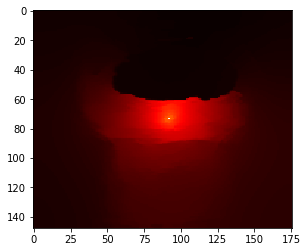

--
alpha: 2^-25
Correlation: 0.00720188002455
Score: 0.00371898984606
Heatmap:



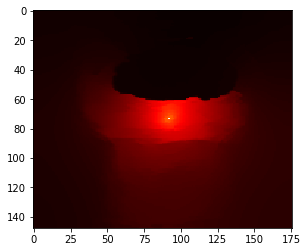

--
alpha: 2^-26
Correlation: 0.00719998777437
Score: 0.0037181929888
Heatmap:



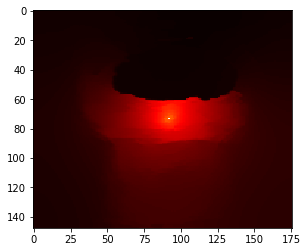

--
alpha: 2^-27
Correlation: 0.00709510294464
Score: 0.00366307433742
Heatmap:



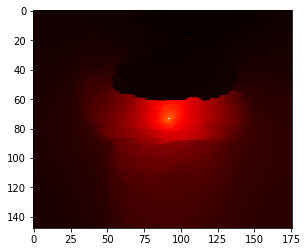

--
alpha: 2^-28
Correlation: 0.0064763220001
Score: 0.00333908498958
Heatmap:



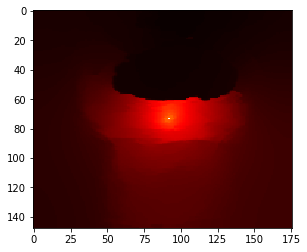

--
alpha: 2^-29
Correlation: 0.00718557678113
Score: 0.00370947693705
Heatmap:



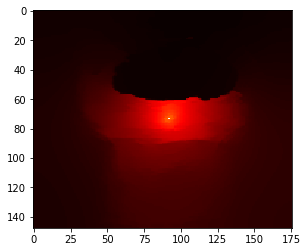

--
alpha: 2^-30
Correlation: 0.00690884277006
Score: 0.00356524133421
Heatmap:



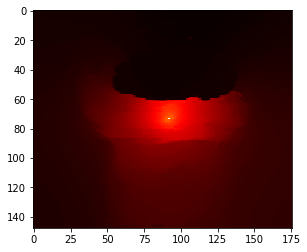

****


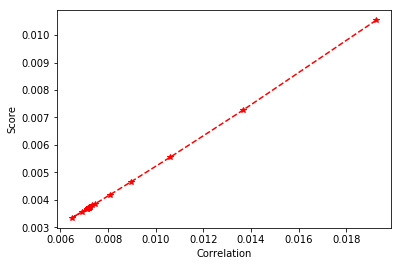

--------Seed [73, 124]
Threshold: 3.839066339066339e-05
--
alpha: 2^-10
Correlation: 0.0239843419445
Score: 0.0120627538092
Heatmap:



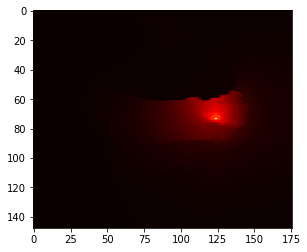

--
alpha: 2^-11
Correlation: 0.0169467442822
Score: 0.0082997737303
Heatmap:



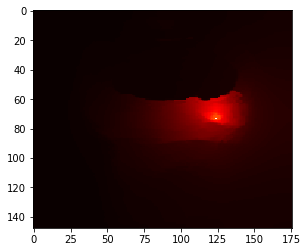

--
alpha: 2^-12
Correlation: 0.0119136910337
Score: 0.0057184107523
Heatmap:



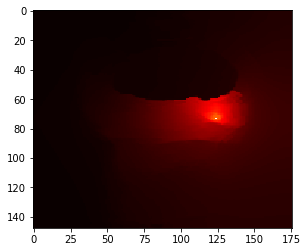

--
alpha: 2^-13
Correlation: 0.0096092824244
Score: 0.00457052395122
Heatmap:



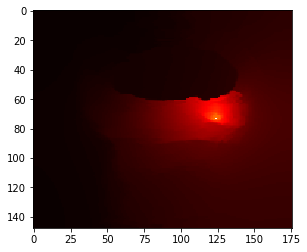

--
alpha: 2^-14
Correlation: 0.00801854712535
Score: 0.00379152940658
Heatmap:



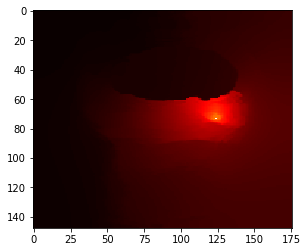

--
alpha: 2^-15
Correlation: 0.0071366840087
Score: 0.00336444404185
Heatmap:



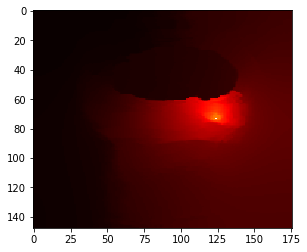

--
alpha: 2^-16
Correlation: 0.00634602087746
Score: 0.00298551481796
Heatmap:



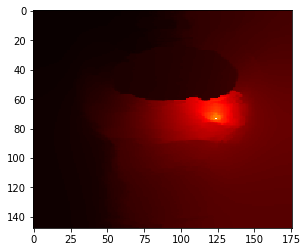

--
alpha: 2^-17
Correlation: 0.00601374767098
Score: 0.00282678665496
Heatmap:



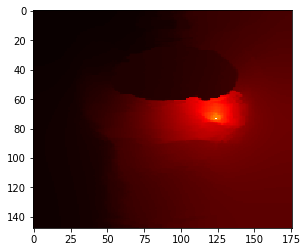

--
alpha: 2^-18
Correlation: 0.00617495026403
Score: 0.00290385071194
Heatmap:



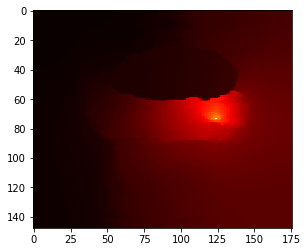

--
alpha: 2^-19
Correlation: 0.00594465350377
Score: 0.00279409638451
Heatmap:



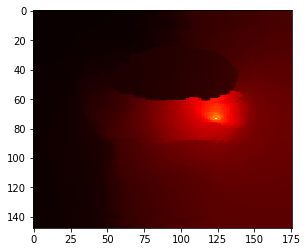

--
alpha: 2^-20
Correlation: 0.00574093687784
Score: 0.00269718154087
Heatmap:



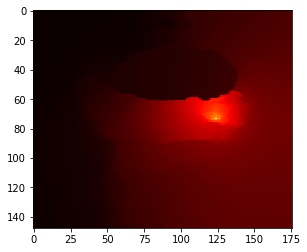

--
alpha: 2^-21
Correlation: 0.00536348291232
Score: 0.00251831052959
Heatmap:



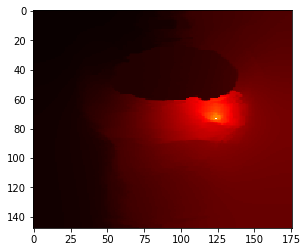

--
alpha: 2^-22
Correlation: 0.00593165611976
Score: 0.00278804444268
Heatmap:



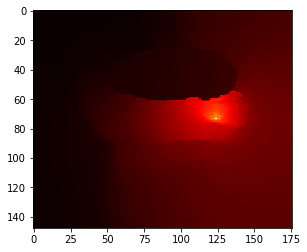

--
alpha: 2^-23
Correlation: 0.00596892165943
Score: 0.00280563598557
Heatmap:



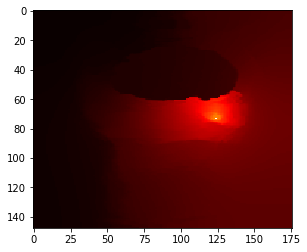

--
alpha: 2^-24
Correlation: 0.00591600174127
Score: 0.00278044451696
Heatmap:



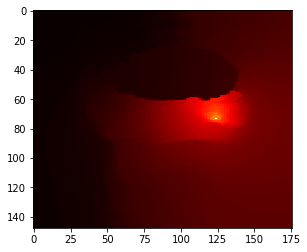

--
alpha: 2^-25
Correlation: 0.00581559291972
Score: 0.00273277697656
Heatmap:



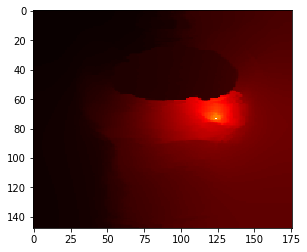

--
alpha: 2^-26
Correlation: 0.00606188454037
Score: 0.00284981445006
Heatmap:



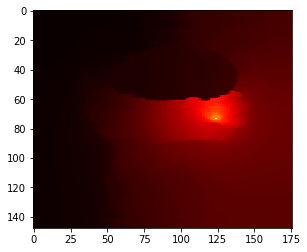

--
alpha: 2^-27
Correlation: 0.00608768064128
Score: 0.00286194246726
Heatmap:



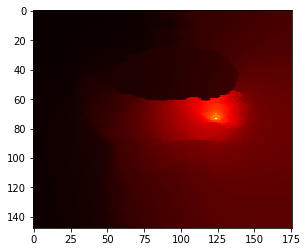

--
alpha: 2^-28
Correlation: 0.00605593436484
Score: 0.00284701285157
Heatmap:



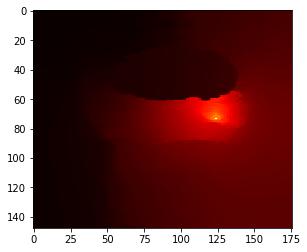

--
alpha: 2^-29
Correlation: 0.00603393272332
Score: 0.0028365336493
Heatmap:



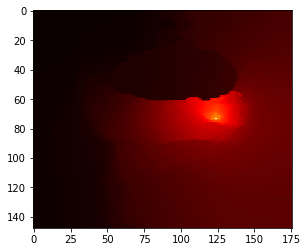

--
alpha: 2^-30
Correlation: 0.00580535194211
Score: 0.00272774146162
Heatmap:



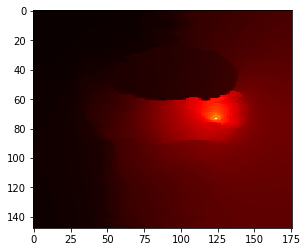

****


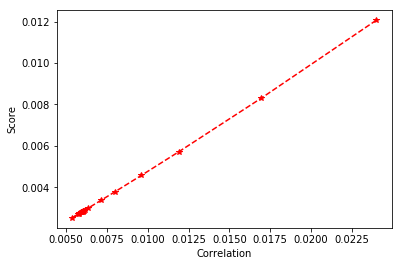

--------Seed [121, 60]
Threshold: 3.839066339066339e-05
--
alpha: 2^-10
Correlation: 0.0309295740441
Score: 0.018462779414
Heatmap:



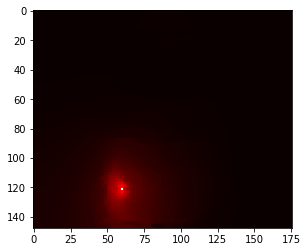

--
alpha: 2^-11
Correlation: 0.018429896141
Score: 0.0107024832545
Heatmap:



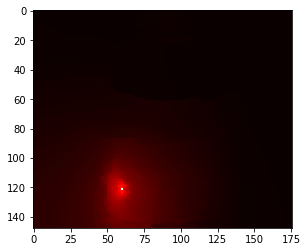

--
alpha: 2^-12
Correlation: 0.0116764957591
Score: 0.00663731272397
Heatmap:



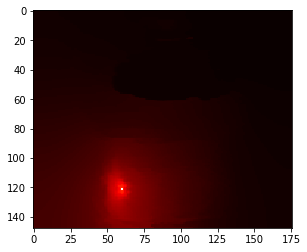

--
alpha: 2^-13
Correlation: 0.0077447246536
Score: 0.00433300669095
Heatmap:



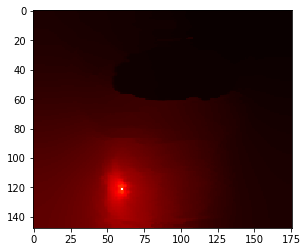

--
alpha: 2^-14
Correlation: 0.00611799315681
Score: 0.00339855582094
Heatmap:



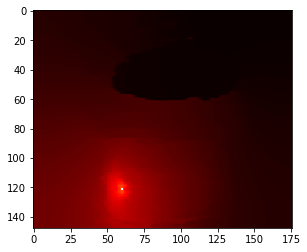

--
alpha: 2^-15
Correlation: 0.00499797480352
Score: 0.00276362819854
Heatmap:



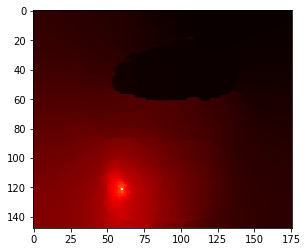

--
alpha: 2^-16
Correlation: 0.00432102747885
Score: 0.00238363930872
Heatmap:



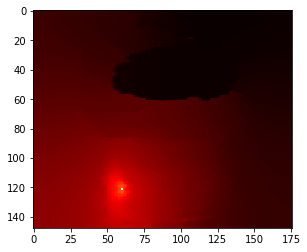

--
alpha: 2^-17
Correlation: 0.00459670573879
Score: 0.0025374124401
Heatmap:



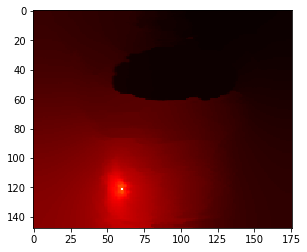

--
alpha: 2^-18
Correlation: 0.00433274525472
Score: 0.00238998982307
Heatmap:



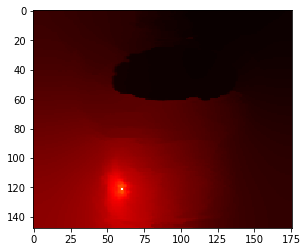

--
alpha: 2^-19
Correlation: 0.00392003763068
Score: 0.00216031367122
Heatmap:



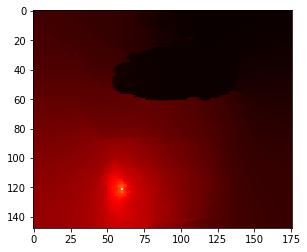

--
alpha: 2^-20
Correlation: 0.00420900025639
Score: 0.00232123646714
Heatmap:



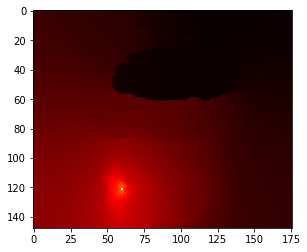

--
alpha: 2^-21
Correlation: 0.00415660344158
Score: 0.00229216877055
Heatmap:



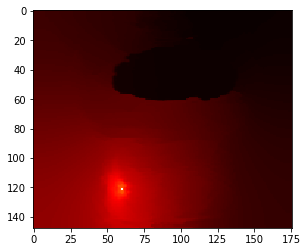

--
alpha: 2^-22
Correlation: 0.004325397494
Score: 0.00238607761568
Heatmap:



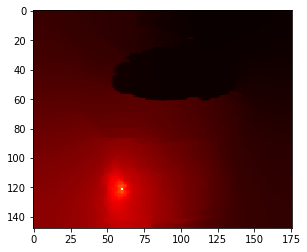

--
alpha: 2^-23
Correlation: 0.00416985385456
Score: 0.002299777487
Heatmap:



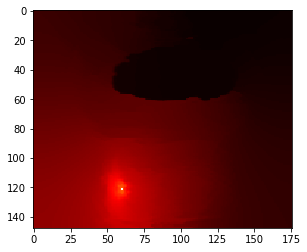

--
alpha: 2^-24
Correlation: 0.00422391038244
Score: 0.00232989358818
Heatmap:



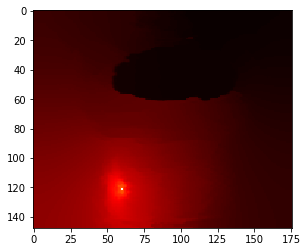

--
alpha: 2^-25
Correlation: 0.00416623028369
Score: 0.00229768676392
Heatmap:



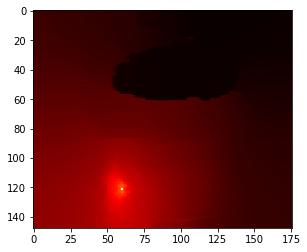

--
alpha: 2^-26
Correlation: 0.00423907919607
Score: 0.00233802048096
Heatmap:



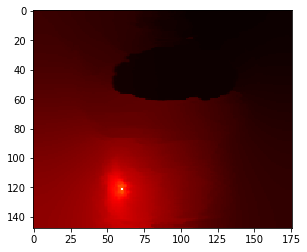

--
alpha: 2^-27
Correlation: 0.00424703924292
Score: 0.0023424546555
Heatmap:



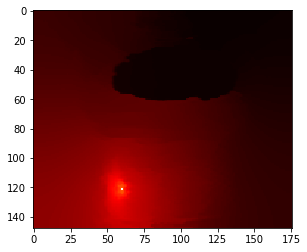

--
alpha: 2^-28
Correlation: 0.00410469172491
Score: 0.00226345707028
Heatmap:



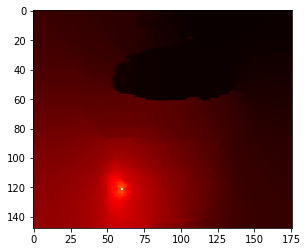

--
alpha: 2^-29
Correlation: 0.00425244039678
Score: 0.00234567425223
Heatmap:



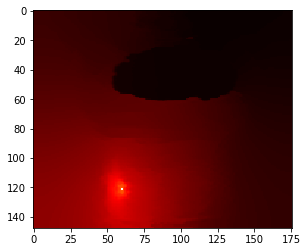

--
alpha: 2^-30
Correlation: 0.00408072269012
Score: 0.00225018629205
Heatmap:



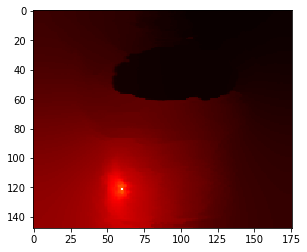

****


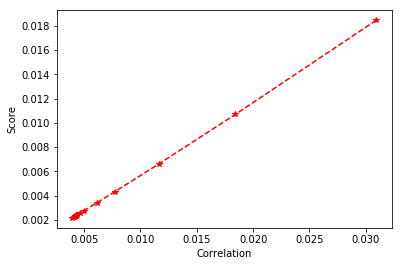

--------Seed [121, 92]
Threshold: 3.839066339066339e-05
--
alpha: 2^-10
Correlation: 0.0221450876704
Score: 0.0131192383382
Heatmap:



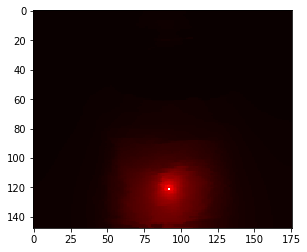

--
alpha: 2^-11
Correlation: 0.013329584859
Score: 0.00760199604131
Heatmap:



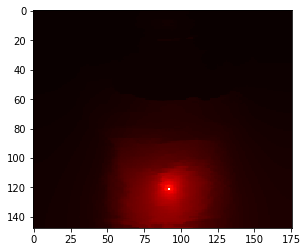

--
alpha: 2^-12
Correlation: 0.00880180047347
Score: 0.00488854139021
Heatmap:



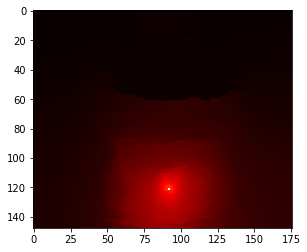

--
alpha: 2^-13
Correlation: 0.00660738383072
Score: 0.00361792829346
Heatmap:



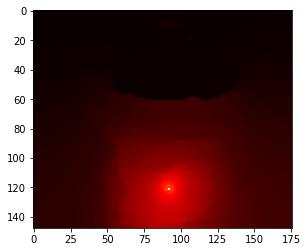

--
alpha: 2^-14
Correlation: 0.00549823498544
Score: 0.0029894745059
Heatmap:



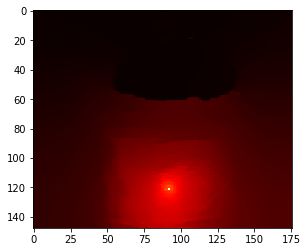

--
alpha: 2^-15
Correlation: 0.0048912048575
Score: 0.00265174710815
Heatmap:



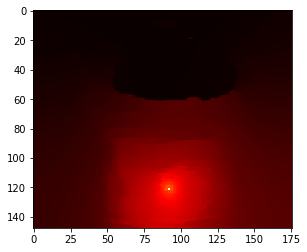

--
alpha: 2^-16
Correlation: 0.00459232514888
Score: 0.00248652863471
Heatmap:



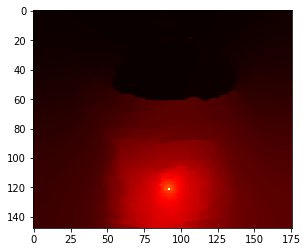

--
alpha: 2^-17
Correlation: 0.00434707049426
Score: 0.00235131476148
Heatmap:



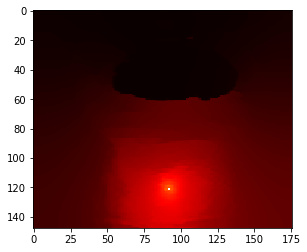

--
alpha: 2^-18
Correlation: 0.00421402900409
Score: 0.00227926870979
Heatmap:



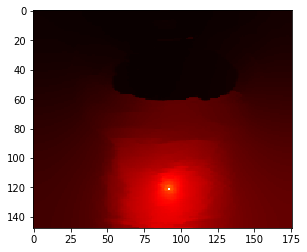

--
alpha: 2^-19
Correlation: 0.00435599807114
Score: 0.00235565106351
Heatmap:



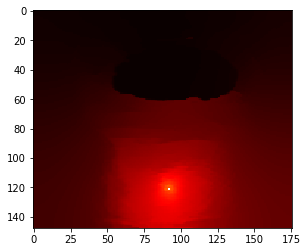

--
alpha: 2^-20
Correlation: 0.00448777253727
Score: 0.00242814408448
Heatmap:



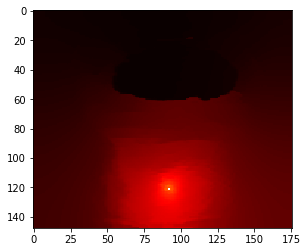

--
alpha: 2^-21
Correlation: 0.00433385402364
Score: 0.00234444427933
Heatmap:



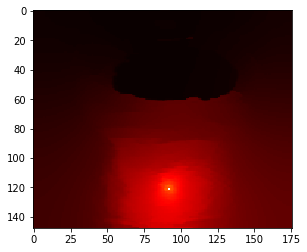

--
alpha: 2^-22
Correlation: 0.00413534008451
Score: 0.00223641472393
Heatmap:



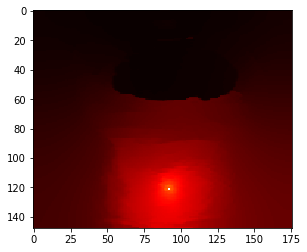

--
alpha: 2^-23
Correlation: 0.00411951275201
Score: 0.00222772793239
Heatmap:



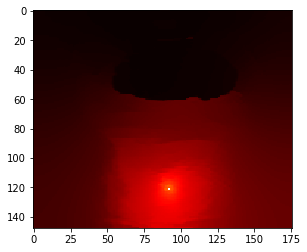

--
alpha: 2^-24
Correlation: 0.00430890313159
Score: 0.00233109853029
Heatmap:



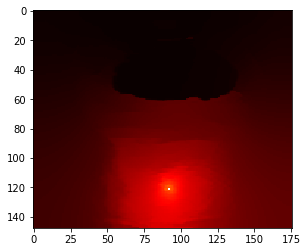

--
alpha: 2^-25
Correlation: 0.0042530849638
Score: 0.00230011312635
Heatmap:



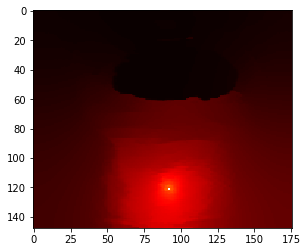

--
alpha: 2^-26
Correlation: 0.00404222763748
Score: 0.00218511226569
Heatmap:



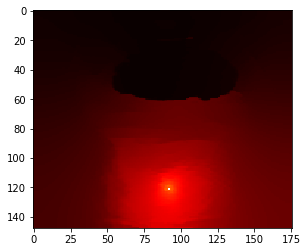

--
alpha: 2^-27
Correlation: 0.0042774631883
Score: 0.00231392214567
Heatmap:



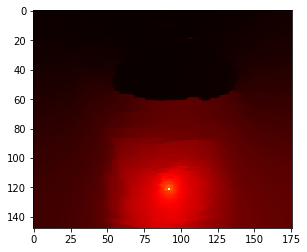

--
alpha: 2^-28
Correlation: 0.00427863611944
Score: 0.00231444411836
Heatmap:



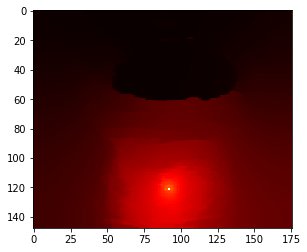

--
alpha: 2^-29
Correlation: 0.00425164422456
Score: 0.00229929006078
Heatmap:



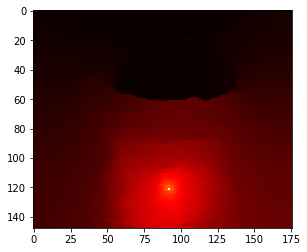

--
alpha: 2^-30
Correlation: 0.00422960951872
Score: 0.00228763313887
Heatmap:



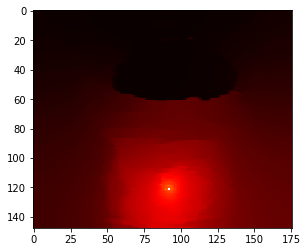

****


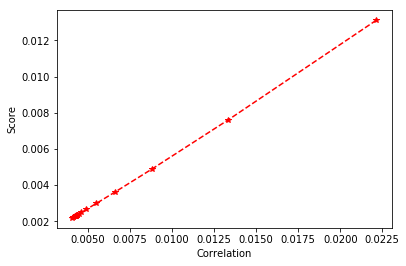

--------Seed [121, 124]
Threshold: 3.839066339066339e-05
--
alpha: 2^-10
Correlation: 0.0251873634486
Score: 0.0146928249155
Heatmap:



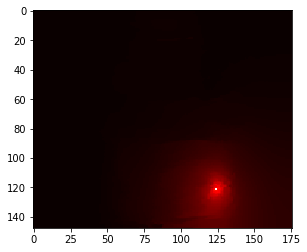

--
alpha: 2^-11
Correlation: 0.0134334193648
Score: 0.0075080218843
Heatmap:



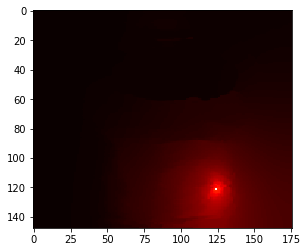

--
alpha: 2^-12
Correlation: 0.00807807550665
Score: 0.0043679023343
Heatmap:



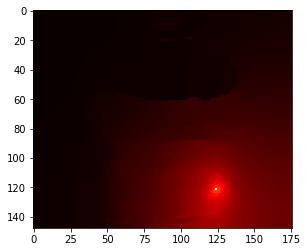

--
alpha: 2^-13
Correlation: 0.00538664028382
Score: 0.00284592996921
Heatmap:



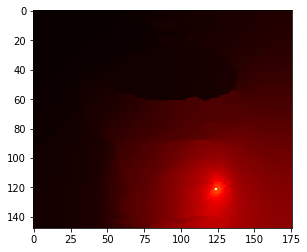

--
alpha: 2^-14
Correlation: 0.00402254529131
Score: 0.00209628750978
Heatmap:



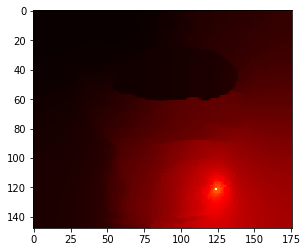

--
alpha: 2^-15
Correlation: 0.00343007087498
Score: 0.00177896520816
Heatmap:



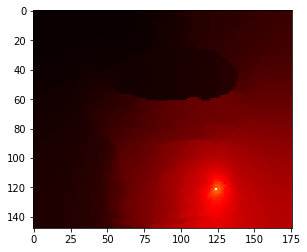

--
alpha: 2^-16
Correlation: 0.00316827857129
Score: 0.00164065500174
Heatmap:



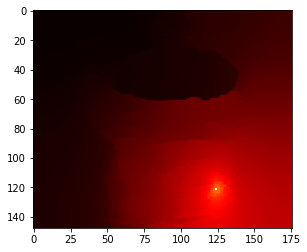

--
alpha: 2^-17
Correlation: 0.00299593572444
Score: 0.0015500348558
Heatmap:



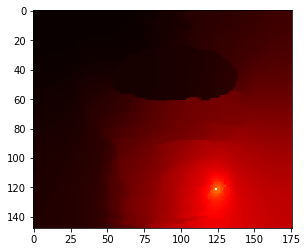

--
alpha: 2^-18
Correlation: 0.00287524542062
Score: 0.00148673304973
Heatmap:



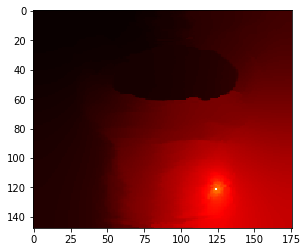

--
alpha: 2^-19
Correlation: 0.00285289109487
Score: 0.00147500908058
Heatmap:



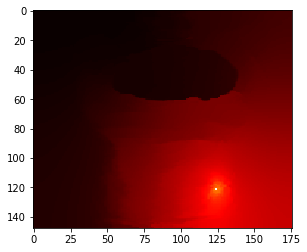

--
alpha: 2^-20
Correlation: 0.00285934674858
Score: 0.00147786204823
Heatmap:



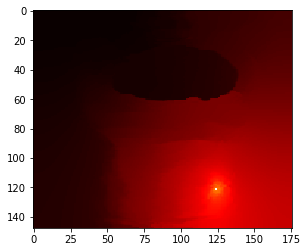

--
alpha: 2^-21
Correlation: 0.00285730895318
Score: 0.00147728416752
Heatmap:



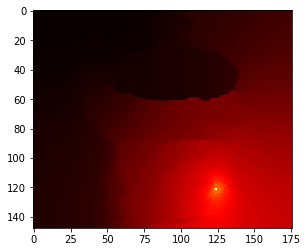

--
alpha: 2^-22
Correlation: 0.00284503741401
Score: 0.00147100873019
Heatmap:



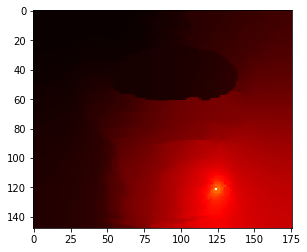

--
alpha: 2^-23
Correlation: 0.00290244812329
Score: 0.00150100738534
Heatmap:



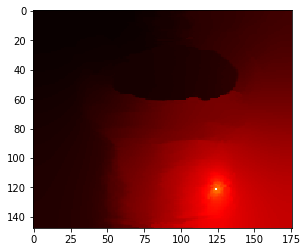

--
alpha: 2^-24
Correlation: 0.00285291935742
Score: 0.00147479909977
Heatmap:



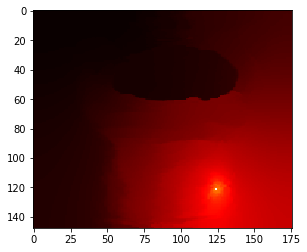

--
alpha: 2^-25
Correlation: 0.00292120245267
Score: 0.00151064293202
Heatmap:



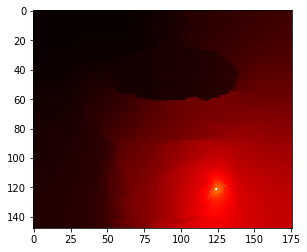

--
alpha: 2^-26
Correlation: 0.00284341143388
Score: 0.00147007752175
Heatmap:



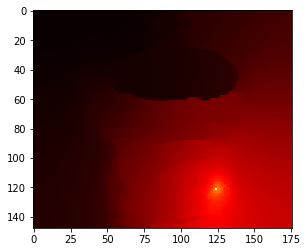

--
alpha: 2^-27
Correlation: 0.00282224228205
Score: 0.00145911067618
Heatmap:



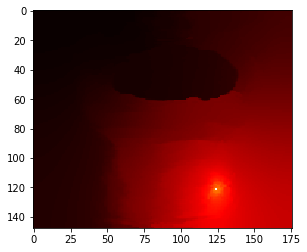

--
alpha: 2^-28
Correlation: 0.00281692184465
Score: 0.00145608051864
Heatmap:



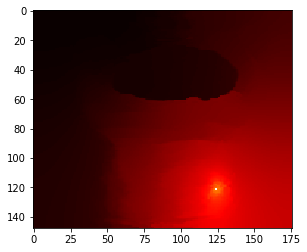

--
alpha: 2^-29
Correlation: 0.0027928522122
Score: 0.00144380544642
Heatmap:



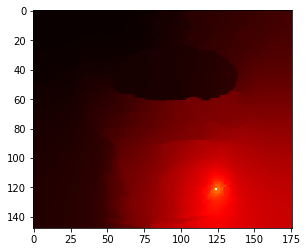

--
alpha: 2^-30
Correlation: 0.00282097767803
Score: 0.00145847344062
Heatmap:



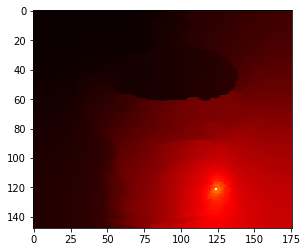

****


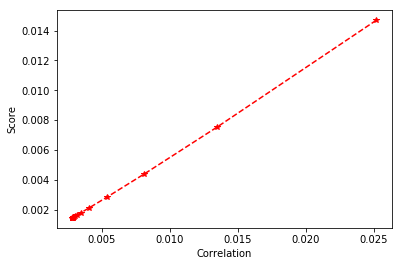

In [6]:
for elem in seedList[2:]:
    print('--------Seed ' + str(elem))
    point = elem[0] * myImg.shape[1] + elem[1]
    seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
    seed[point] = 1
    
    [alphaList, correlationList, scoreList, valueList] = PRobjective(graph, seed, myImg)

    # Saving
    alphaListList.append(alphaList)
    correlationListList.append(correlationList)
    scoreListList.append(scoreList)
    valueListList.append(valueList)

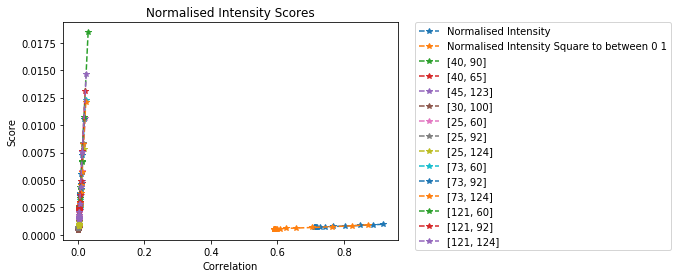

In [7]:
for i in range(len(correlationListList)):
    plt.plot(correlationListList[i], scoreListList[i], '*--')
plt.legend(seedList, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
plt.show()

In [8]:
save_array(IMAGE + '_01-23-18' + '/' + 'alphaListList.data', alphaListList)
save_array(IMAGE + '_01-23-18' + '/' + 'correlationListList.data', correlationListList)
save_array(IMAGE + '_01-23-18' + '/' + 'scoreListList.data', scoreListList)
save_array(IMAGE + '_01-23-18' + '/' + 'valueListList.data', valueListList)
save_array(IMAGE + '_01-23-18' + '/' + 'seedList.data', seedList[2:])

In [6]:
alphaListListRecovered = load_array(IMAGE + '_01-23-18' + '/' + 'alphaListList.data')
correlationListListRecovered = load_array(IMAGE + '_01-23-18' + '/' + 'correlationListList.data')
scoreListListRecovered = load_array(IMAGE + '_01-23-18' + '/' + 'scoreListList.data')
valueListListRecovered = load_array(IMAGE + '_01-23-18' + '/' + 'valueListList.data')
seedListRecovered = ['Normalised Intensity', 'Normalised Intensity Square to between 0 1']
seedListRecovered[2:] = load_array(IMAGE + '_01-23-18' + '/' + 'seedList.data')

Print with saved arrays for future usage


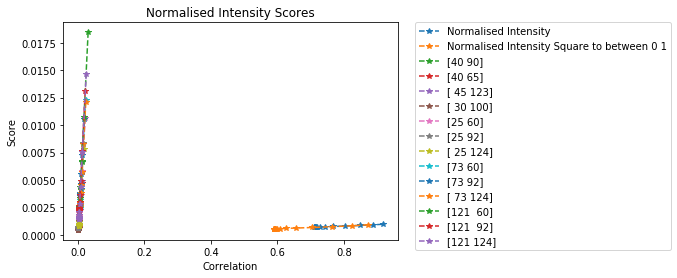

In [10]:
print('Print with saved arrays for future usage')
for i in range(len(correlationListListRecovered)):
    plt.plot(correlationListListRecovered[i], scoreListListRecovered[i], '*--')
plt.legend(seedListRecovered, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
# plt.axis([.8,1,0,1])
plt.show()

Print with saved arrays for future usage


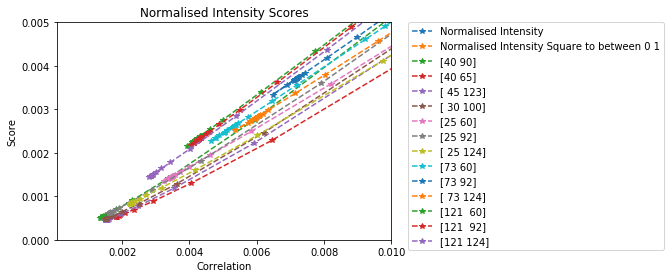

In [9]:
print('Print with saved arrays for future usage')
for i in range(len(correlationListListRecovered)):
    plt.plot(correlationListListRecovered[i], scoreListListRecovered[i], '*--')
plt.legend(seedListRecovered, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
plt.axis([1/20000, 1/100, 0, .005])
plt.show()